In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import random
import gc
from time import time
random.seed(11)
%matplotlib inline
sns.set()

# Introduction

This project is drawn from a <a href=https://www.kaggle.com/c/home-credit-default-risk/kernels>Kaggle competition</a> (ends Aug 29. 2018) to predict loan outcomes.  Here's the official description:

*Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.*

*Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.*

*While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.*

The dataset consists of seven tables: one main table with essential data for every loan example, and six subsidiary tables (e.g., previous application data) which may or may not have entries for any given loan listed in the main table.  The evaluation criterion is the area under the model's ROC curve.

### Challenges
The most obviously formidable challenge in this competition is the dataset, which is medium quantity, mixed type, high opacity, and high sparsity.  To clarify:

<img src="vis2.png" style="width:450px;padding-right:30px" align="left">
- <b>Medium/high quantity:</b> at 300K examples and 122 features in the main table alone, the dataset is large enough to impose some computational limits (or at least inconveniences) on our models and processes<br><br>
- <b>Mixed type:</b> the features are a mix of quantitative, multi-categorical, and binary-categorical.  As most models can only handle quantitative or binary features, we face the choice of dropping features or ballooning dimensionality with dummy columns.<br><br>
- <b>High opacity:</b> the nature of the data is poorly explained (column descriptions, where extant, are single-clause and non-American English), and we have no information about how it was collected.  This makes cleaning highly problematic.<br><br>
- <b>High sparsity:</b> the subsidiary tables have entries for some example loans and not for others; and even the primary table with all our example loans is strewn with nulls.<br><br>
- <b>Non-linearity:</b> there are no clear linear boundaries between positive and negative examples, as evident in the image at left.

In particular, the combination of high opacity and high sparsity means that there will be a lot of guesswork involved in handling our null values.  The non-linearity of the positive-negative division - in fact, they look quite randomly mixed in this plot - indicates that separating out the positives is likely to be a very difficult task.  

### My approach
I'm going to begin by cleaning up the main table to produce a workable dataset.  I'll then run an array of basic models on this dataset to generate accuracy benchmarks and decide which model or models should be our main choice to optimize later.  Given the challenges described above, the best out-of-box models will probably be the newer gradient boosting models which are highly optimized and well-equipped to handle categorical variables (XGBoost, LightGBM, CatBoost).

Once we've established our best model type(s), we'll move on to feature engineering.  This will include various approaches to engineering combined features, imputing missing values, incorporating the ancillary tables, and feature reduction.  For each version of our our dataset, we'll run our working model and check the results against our benchmark to see how much the changes helped or harmed our accuracy.  Using this method, we'll create an optimal version of our dataset for our model to work on.

Finally, having engineered the best set of features we can, we'll run a hyperparameter sweep on our chosen model or models to achieve our highest possible accuracy score.  The pipeline of data transforms, feature engineering, and optimally-tuned model will constitute our complete predictive model.

### Goals
The public kernels for this dataset tend to produce AUROC scores between 0.73 and 0.79, with a maximum around 0.794. The leaderboard scores range from 0.801 to 0.807.  My goal for this project is to get up to 0.800, which would put me at least on the leaderboard.  This will be a significant challenge, since the dataset seems to be pretty recalcitrant past 0.78.

It's also worth noting that my test scores here will mostly be trained on only a portion of the training data, with the other portion withheld for testing.  The official leaderboard score is produced by training on *all* of the training data and testing on 20% of the test data (the official final score will be tested on the other 80% of the training data).  So my test scores here will be a bit lower, and I'll have to actually submit to discover how much uptick the increase in data will produce.

# Load and clean

In [2]:
raw_apps_df = pd.read_csv("application_train.csv")
raw_apps_df.columns = [str.lower(column) for column in raw_apps_df.columns]

First we'll handle a few type fixes that we'll want done even for our raw dataset:

In [3]:
# convert Y/N to True/False booleans:
raw_apps_df['flag_own_car'] = raw_apps_df.flag_own_car=='Y'
raw_apps_df['flag_own_realty'] = raw_apps_df.flag_own_realty=='Y'
# convert gender M/F flag to boolean:
raw_apps_df['gender_female'] = raw_apps_df['code_gender']=='F'
raw_apps_df.drop('code_gender', axis=1, inplace=True)
# convert mistyped float/str column:
raw_apps_df['ext_source_1'] = raw_apps_df.ext_source_1.astype(float)

In [636]:
print(raw_apps_df.shape)
raw_apps_df.head()

(307511, 122)


,sk_id_curr,target,name_contract_type,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,...,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,gender_female
0,100002,1,Cash loans,False,True,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,False
1,100003,0,Cash loans,False,False,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,True
2,100004,0,Revolving loans,True,True,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
3,100006,0,Cash loans,False,True,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,True
4,100007,0,Cash loans,False,True,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False


# Preparing the data: manual null elimination and feature combination

We're going to try several types of data preparation for our models.  For our initial examination and model testing, we'll want a manageably-sized and null-less dataset.  Later, when we use some feature reduction algorithms that can handle nulls directly, we'll want a version with the most basic cleaning and consolidation performed, but with most of the nulls left intact.

Here we'll begin with the basic cleaning and consolidation to produce a minimally prepped version of the dataset: *apps_df*.  We'll then create another version that's further consolidated and has all the nulls filled: *apps_small_df*.  We'll use the latter table for our data exploration and initial model testing.

#### A note on the housing columns: 
The columns describing client housing are numerous (46) and strewn with nulls.  They are all normalized to a 0-to-1 range, with numbers closer to zero representing lower quality or less expensive housing (e.g., small number of rooms, entrances, square feet).

Since many of the nulls represent legitimate zeros (has no basement square footage, or no non-living-rooms, or no home at all), most of the nulls probably represent zeros.  The only clear exception is years_build_medi, which represents the age of the building.  Since zero represents a new building, we can fill nulls with a 0.5 for average age.  

We can then combine all housing columns (other than housing age, where 0 is higher quality) into one column that represents the accumulated quality and expensiveness of the housing.  This combination will lose some data, but it's pretty arcane stuff that's unlikely to be individually significant, and cutting it will provide a large and helpful reduction in dimensionality.

In [4]:
apps_df = raw_apps_df.copy()

In [5]:
# we're going to rename housing age and move it to the end so that it's kept separate from our housing quality score
apps_df['housing_age'] = apps_df.years_build_medi
apps_df.drop('years_build_medi', axis=1, inplace=True)

# the nulls for who was with the person when they applied should be 'Unaccompanied'
apps_df['name_type_suite'].fillna(value='Unaccompanied', inplace=True)

housing_cols = apps_df.columns[43:84]
housing_categoricals = ['fondkapremont_mode', 'housetype_mode', 'wallsmaterial_mode', 'emergencystate_mode']
apps_df['housing_null_count'] = apps_df[housing_cols].isnull().sum(axis=1)
apps_df['other_null_count'] = apps_df.isnull().sum(axis=1)
apps_df['housing_quality'] = apps_df[housing_cols].sum(axis=1)
# NOTE: the above sum function effectively imputes 0s for nulls, which is okay 
# since no basement area generally means no basement

That's all the cleaning and consolidation we need for our full dataset.  

Now let's create the smaller null-less dataset for initial exploration and testing:

In [6]:
apps_small_df = apps_df.copy()

apps_small_df.drop(housing_cols, axis=1, inplace=True)
apps_small_df.drop('totalarea_mode', axis=1, inplace=True)

# almost all of the credit bureau call and social circle values are zero (median=0), 
# so we'll just manually impute zeroes for those:
for colname in ['amt_req_credit_bureau_hour', 
                'amt_req_credit_bureau_day',
                'amt_req_credit_bureau_week', 
                'amt_req_credit_bureau_mon', 
                'amt_req_credit_bureau_qrt', 
                'amt_req_credit_bureau_year',
                'obs_30_cnt_social_circle',
                'def_30_cnt_social_circle',
                'obs_60_cnt_social_circle',
                'def_60_cnt_social_circle']:
    apps_small_df[colname].fillna(value=0, inplace=True)
    
# there are columns have only a few nulls (270, 23, 2, 1); we'll impute the median
apps_small_df['amt_goods_price'].fillna(value=450000, inplace=True)  
apps_small_df['amt_annuity'].fillna(value=24903, inplace=True)  
apps_small_df['cnt_fam_members'].fillna(value=2, inplace=True)  
apps_small_df['days_last_phone_change'].fillna(value=-757, inplace=True)

apps_small_df.housing_age.fillna(0.5, inplace=True)

# we'll group all void occupation types into 'Other/unemployed' since it's not clear whether
# the existing category 'Laborer' means 'Other'
apps_small_df['occupation_type'].fillna(value='Unemployed/other', inplace=True)

# for vehicle age, we'll say that having no car is like having a really old car
apps_small_df['own_car_age'].fillna(value=75, inplace=True)

apps_small_df[housing_categoricals] = apps_small_df[housing_categoricals].fillna(value='Unknown')

# and for the external data sources we'll just impute the median of 0.5
for colname in ['ext_source_1', 'ext_source_2', 'ext_source_3']:
    apps_small_df[colname].fillna(value=0.5, inplace=True)
    
# there are columns have only a few nulls (270, 23, 2, 1); we'll impute the median
apps_small_df['amt_goods_price'].fillna(value=450000, inplace=True)  
apps_small_df['amt_annuity'].fillna(value=24903, inplace=True)  
apps_small_df['cnt_fam_members'].fillna(value=2, inplace=True)  
apps_small_df['days_last_phone_change'].fillna(value=-757, inplace=True)

# Only three of the 20 document-submitted-flag columns have more than 10% submission rates.  The rest are very low, 
# with mostly only a few submissions out of 700K applicants.  We'll combine these.
docs_to_sum = [col for col in apps_small_df.columns[52:72] 
               if col not in ['flag_document_3', 'flag_document_6', 'flag_document_8']]
apps_small_df['other_docs_submitted'] = apps_small_df[docs_to_sum].sum(axis=1)
apps_small_df.drop(docs_to_sum, axis=1, inplace=True)

# some more column consolidation:
req_cols = ['amt_req_credit_bureau_hour', 
            'amt_req_credit_bureau_day',
            'amt_req_credit_bureau_week', 
            'amt_req_credit_bureau_mon', 
            'amt_req_credit_bureau_qrt', 
            'amt_req_credit_bureau_year']
apps_small_df['amt_req'] = apps_small_df[req_cols].sum(axis=1)
apps_small_df.drop(req_cols, axis=1, inplace=True)

soc_cols = ['obs_30_cnt_social_circle',
            'def_30_cnt_social_circle',
            'obs_60_cnt_social_circle',
            'def_60_cnt_social_circle']
apps_small_df['soc_cols'] = apps_small_df[soc_cols].sum(axis=1)
apps_small_df.drop(soc_cols, axis=1, inplace=True)

In [7]:
print("Small dataset feature count: ", apps_small_df.shape[1])
print("Large dataset feature count: ", apps_df.shape[1])

Small dataset feature count:  59
Large dataset feature count:  125


# Examining the data

### Outcome distribution

First, let's take a look at our target variable distribution.

In [641]:
apps_df.target.value_counts()

0    282686
1     24825
Name: target, dtype: int64

This is definitely an imbalanced dataset (8% positives), but it's not terribly skewed.  The easiest way to address this will be adding class weights to our models.

Since it's most important not to give loans that will default, we want to place some priority on catching all defaults (i.e., all positives), which means eliminating false negatives.  Given this priority, f1-score makes sense as a measure that emphasizes positives identification (it doesn't incorporate true negatives in its formula).  Throughout our testing, we'll check f1-score as well as the AUROC score that is the official score for the contest.  The f1-score will also alert us by zeroing out if a model is getting a decent AUROC score simply by predicting all negatives (which would by 92% correct, but useless).

### Core features distribution

Let's take a look at the distributions of income levels, loan amounts, and loan annuities:

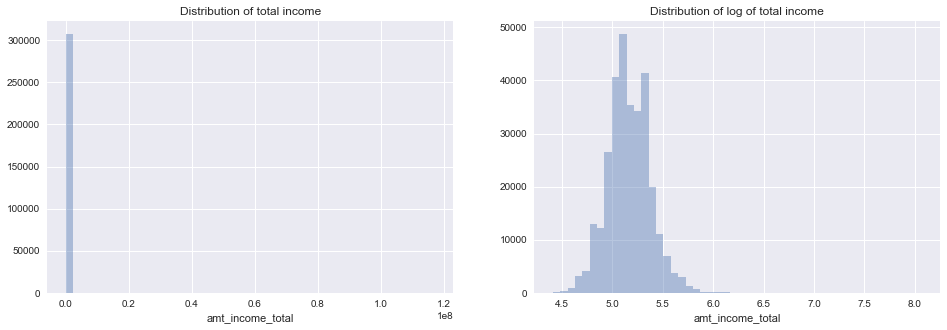

In [97]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(apps_df.amt_income_total, kde=False)
plt.title("Distribution of total income")
plt.subplot(1,2,2)
sns.distplot(np.log10(apps_df.amt_income_total), kde=False)
plt.title("Distribution of log of total income")
plt.show()

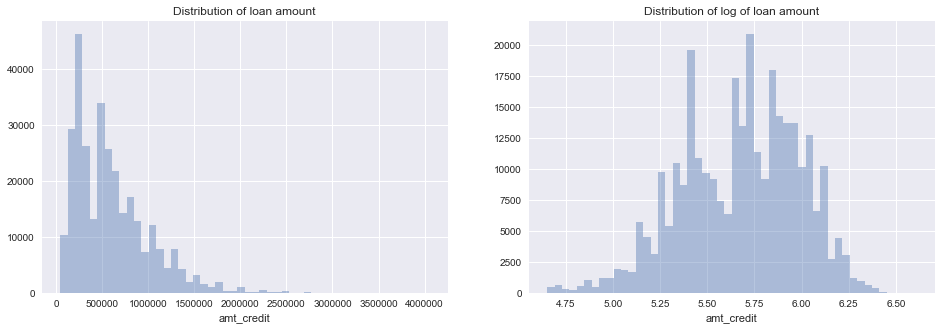

In [98]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(apps_df.amt_credit, kde=False)
plt.title("Distribution of loan amount")
plt.subplot(1,2,2)
sns.distplot(np.log10(apps_df.amt_credit), kde=False)
plt.title("Distribution of log of loan amount")
plt.show()

In [101]:
apps_df.amt_annuity.isnull().sum()

12

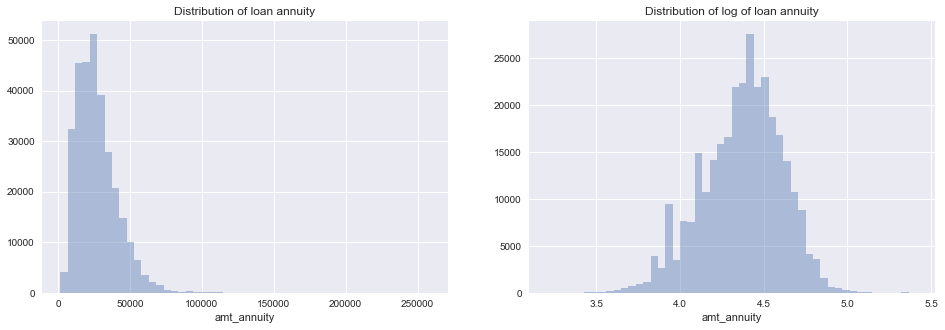

In [104]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(apps_df.amt_annuity, kde=False)
plt.title("Distribution of loan annuity")
plt.subplot(1,2,2)
sns.distplot(np.log10(apps_df.amt_annuity), kde=False)
plt.title("Distribution of log of loan annuity")
plt.show()

For all three of these statistics, a log transform is required to achieve a normal distribution.  Since many models assume normality (or at least work better with normally distributed features), we probably want to apply the log transform to the features in our dataset.  First, though, let's take a look at their scatterplot:

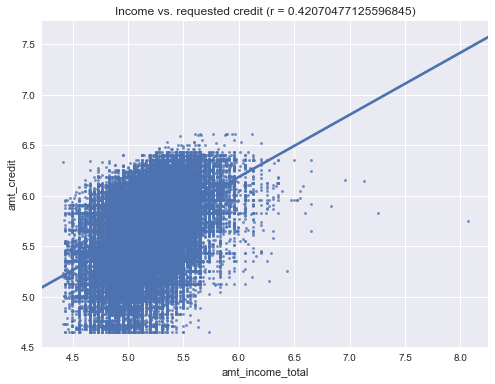

In [105]:
from scipy.stats import pearsonr
plt.figure(figsize=(8,6))
x = np.log10(apps_df.amt_income_total)
y = np.log10(apps_df.amt_credit)
sns.regplot(x,y, scatter_kws={'s':8})
pcc = pearsonr(x,y)[0]
plt.title("Income vs. requested credit (r = {})".format(pcc))
plt.show()

This tells us several things.  First, amount of income and amount of loan are strongly correlated (no surprise therE).  Second, there are a couple large outliers in our dataset where the income amount is over 10 million.  These might be worth eliminating, given that they're likely to be throw off our broader patterns.

Third, we can see that our minima display pretty hard cutoffs.  The smallest loans requested are 45,000 (units unknown); given that there are 230 loan requests of this amount and none of 50,000, it probably represents a minumum amount policy.  The smallest income reported is 25,650 (units unspecified); the income amounts display a more gradual decay toward the minum, however.

Given what we've learned, let's drop our three largest outliers.  And we'll add log versions of amt_credit and amt_income_total in our engineered features in the section below.

In [8]:
apps_df = apps_df[apps_df.amt_income_total < 1e7]
apps_small_df = apps_small_df[apps_small_df.amt_income_total < 1e7]

Are there differences in these patterns between loans that did vs didn't result in repayment difficulties?

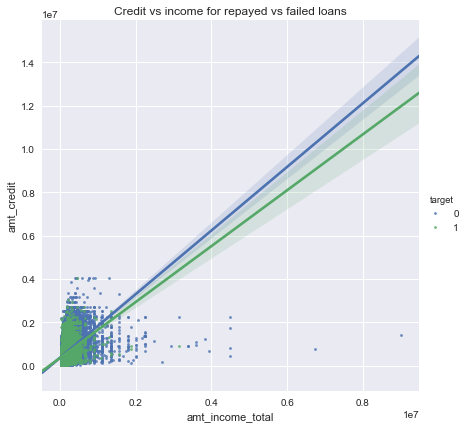

In [107]:
sns.lmplot(x='amt_income_total', y='amt_credit', hue='target', data=apps_df, size=6, scatter_kws={'s':8})
plt.title("Credit vs income for repayed vs failed loans")
plt.show()

It seems that there's actually a lower correlation between income and loan amount for failed loans than for loans with no repayment problem.  There are also simply fewer failed loans at high amounts of income OR credit.  Together, these probably indicate a higher degree of risk aversion from the creditor for larger loans.

### Correlations & redundancies

Now let's take a look at our variable correlations and see if any are too redundant to keep as separate features.

In [ ]:
non_binary_cols = [colname for colname in apps_df.columns if not colname.startswith('flag')]
corr = apps_small_df[non_binary_cols].corr()

# throws super perplexing KeyError!!!
# persists even with non_binary_cols = [colname.replace('\n', '') for colname in apps_df.columns if not colname.startswith('flag')]

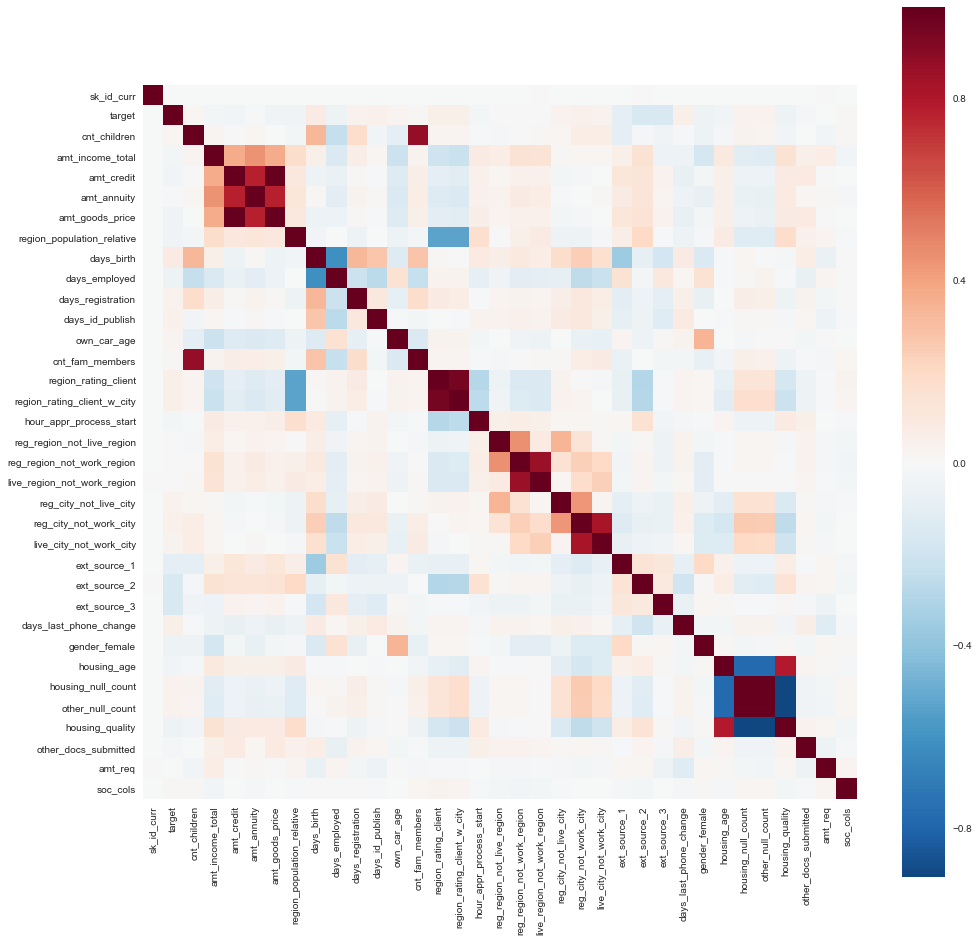

In [109]:
binary_cols = ['flag_own_car', 'flag_own_realty', 'flag_mobil', 'flag_emp_phone', 'flag_work_phone', 'flag_cont_mobile', 'flag_phone', 'flag_email', 'flag_document_3', 'flag_document_6', 'flag_document_8']
corr = apps_small_df.drop(binary_cols, axis=1).corr()
plt.figure(figsize=(16,16))
sns.heatmap(corr, square=True, center=0, cmap='RdBu_r');
plt.show()

Based on these correlations, we can remove a few features from our datasets:

In [9]:
redundant_cols = ['housing_null_count',
                  'amt_goods_price', 
                  'cnt_fam_members', 
                  'region_rating_client_w_city', 
                  'live_region_not_work_region', 
                  'live_city_not_work_city']
# note: housing age is borderline-redundante with housing quality and could potentially be dropped as well

# apps_df.drop(redundant_cols, axis=1, inplace=True)
apps_small_df.drop(redundant_cols, axis=1, inplace=True)

### Encoding categorical variables

Some of our basic models won't be able to handle categorical variables directly.  We'll generate a basic encoded dataset to use in those cases.

In [10]:
y = apps_small_df['target']

In [36]:
# define two functions for target_based encoding:
def target_mean_encode(colname, target='target', df=apps_df):
    '''returns column with each value replaced with the mean of target column for that value '''  
    # note: it would be great to use a groupby here, but for reasons that are difficult to fathom,
    # pandas groupby objects don't support access by key
    value_means = {}
    for value in df[colname].unique():
        value_means[value] = round(df[df[colname]==value][target].mean()*100, 1)
    return df[colname].apply(lambda x: value_means[x])

def target_std_encode(colname, target='target', df=apps_df):
    value_stds = {}
    for value in df[colname].unique():
        value_stds[value] = value_stds[value] = round(np.std(df[df[colname]==value][target]*100), 1)
    return df[colname].apply(lambda x: value_stds[x])    

def target_seq_encode(colname, target, df):
    '''returns column with each value replaced by the integer index of the value in a list of values
    sorted by the mean of the target value for that column'''
    value_means = []
    for value in df[colname].unique():
        value_means.append( (value, df[df[colname]==value][target].mean()) )
    value_means = sorted(value_means, key=lambda x: x[1])
    # create dictionary of {value, index-in-list-sorted-by-mean}
    value_seq = {}
    i = 0
    for tup in value_means:
        value_seq[tup[0]] = i
        i+=1
    return df[colname].apply(lambda x: value_seq[x])

In [14]:
# occupation type and organization type have lots of unique values (19 and 59, respectively). 
# We'll numerically them, with the number for a label representing the mean target value for that label:
X_sm_encoded = apps_small_df.copy()
X_sm_encoded['occupation_type_seq'] = target_seq_encode('occupation_type', 'target', X_sm_encoded)
X_sm_encoded['occupation_type'] = target_mean_encode('occupation_type', 'target', X_sm_encoded)
X_sm_encoded['organization_type_seq'] = target_seq_encode('organization_type', 'target', X_sm_encoded)
X_sm_encoded['organization_type'] = target_mean_encode('organization_type', 'target', X_sm_encoded)

X_sm_encoded.drop('target', axis=1, inplace=True)

# we'll one-hot encode the rest of our categorical variables, which all have eight or fewer values
X_sm_encoded = pd.get_dummies(X_sm_encoded)
X_sm_encoded.head()

,sk_id_curr,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,region_population_relative,days_birth,days_employed,...,wallsmaterial_mode_Mixed,wallsmaterial_mode_Monolithic,wallsmaterial_mode_Others,wallsmaterial_mode_Panel,"wallsmaterial_mode_Stone, brick",wallsmaterial_mode_Unknown,wallsmaterial_mode_Wooden,emergencystate_mode_No,emergencystate_mode_Unknown,emergencystate_mode_Yes
0,100002,False,True,0,202500.0,406597.5,24700.5,0.018801,-9461,-637,...,0,0,0,0,1,0,0,1,0,0
1,100003,False,False,0,270000.0,1293502.5,35698.5,0.003541,-16765,-1188,...,0,0,0,0,0,0,0,1,0,0
2,100004,True,True,0,67500.0,135000.0,6750.0,0.010032,-19046,-225,...,0,0,0,0,0,1,0,0,1,0
3,100006,False,True,0,135000.0,312682.5,29686.5,0.008019,-19005,-3039,...,0,0,0,0,0,1,0,0,1,0
4,100007,False,True,0,121500.0,513000.0,21865.5,0.028663,-19932,-3038,...,0,0,0,0,0,1,0,0,1,0


# Model Performance Baselines

Before we move on to feature engineering and feature reduction, we should figure out which models seem to work well on our basic version of this dataset.  We'll take the performances of our top two models on this dataset as our benchmarks.  (Our performance metric, as dictated by the Kaggle contest, is AUROC).  Later, for our more heavily engineered versions of the datset, the performance of these models will be our criterion for determining which modifications (added features, reduced featuresets, etc.) are most helpful.

In particular, we'll try:
- Linear regression (with Stochastic Gradient Descent)
- Naive Bayes
- Random Forest
- XGBoost
- LightGBM
- CatBoost
- SVC with kernel approximation (pure SVC will take a lot of processing time)

In [15]:
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning) # arises with current lightGBM + numpy
# import lightgbm as lgb

In [16]:
from sklearn.metrics import confusion_matrix

def cross_test_model(model, X_set, y):
    start = time()
    scores = cross_validate(model, X_set, y, cv=3, 
                            scoring=['roc_auc', 'f1'], return_train_score=True)
    print("  Mean train AUROC:", round(np.mean(scores['train_roc_auc']), 4))
    print("  Mean test AUROC:", round(np.mean(scores['test_roc_auc']), 4))
    print("  Mean train F1-score:", round(np.mean(scores['train_f1']), 4))
    print("  Mean test F1-score:", round(np.mean(scores['test_f1']), 4))
    print("Mean fit/score time:", round( (np.mean(scores['fit_time']) + np.mean(scores['score_time']))/60, 1),
                                       'minutes') 
def quick_test_model(model, X_set, y):
    start = time()
    X_train, X_test, y_train, y_test = train_test_split(X_set, y, test_size=1/3)
    model.fit(X_train, y_train)
    
    y_train_proba = model.predict_proba(X_train)[:,1]
    y_test_proba = model.predict_proba(X_test)[:,1]
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    train_auroc = round(roc_auc_score(y_train, y_train_proba), 3)
    test_auroc = round(roc_auc_score(y_test, y_test_proba), 3) 
    train_f1 = round(f1_score(y_train, y_pred_train), 3)
    test_f1 = round(f1_score(y_test, y_pred_test), 3)   
    
    print("  train AUROC:", train_auroc)
    print("  test AUROC:", test_auroc)
    print("  train f1-score:", train_f1)
    print("  test f1-score:", test_f1)
    print("elapsed time:", round((time()-start)/60, 1), 'minutes')

def test_models(model_tups, X_set, y):
    ''' model_tups = [ (model, name), (model, name) ]'''
    # note: I formerly use cross_validate as in cross_test_model() above; however, this produced unexpected f1-scores
    # that were very different from a manual sklearn.metrics.f1_score.  (Only on the test scores, oddly.)
    
    warnings.filterwarnings(action='ignore') # UndefinedMetricWarning arises with f1-score of SGD Classifier,
    # which ends up dividing by zero.  In that case the function sets it as a score of 0.  Ignore the warning.
    
    X_train, X_test, y_train, y_test = train_test_split(X_set, y, test_size=1/3)
    
    for tup in model_tups:
        start = time()
        model = tup[0]
        model.fit(X_train, y_train)
        y_train_proba = model.predict_proba(X_train)[:,1]
        y_test_proba = model.predict_proba(X_test)[:,1]
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        train_auroc = round(roc_auc_score(y_train, y_train_proba), 3)
        test_auroc = round(roc_auc_score(y_test, y_test_proba), 3) 
        train_f1 = round(f1_score(y_train, y_pred_train), 3)
        test_f1 = round(f1_score(y_test, y_pred_test), 3)   
        
        print(tup[1] + ':')
        print("  train AUROC:", train_auroc)
        print("  test AUROC:", test_auroc)
        print("  train f1-score:", train_f1)
        print("  test f1-score:", test_f1)
        print("elapsed time:", round((time()-start)/60, 1), 'minutes\n')

def show_conf_mat(model, X_set, y):
    X_train, X_test, y_train, y_test = train_test_split(X_set, y, test_size=1/3)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    plt.figure(figsize=(5,5))
    conf_mat = np.round(confusion_matrix(y_test, y_pred)/len(y_test), 2)
    conf_mat = pd.DataFrame(np.fliplr(np.rot90(conf_mat)), # because sklearn arranges it counter to convention
             columns=['actual_True', 'actual_False'], 
             index=['predicted_True', 'predicted_False'])
    sns.heatmap(conf_mat, square=True, annot=True, annot_kws={'size':16}, cmap='RdBu_r', center=0, fmt='g')
    plt.title('confusion matrix (shows percentage of \n full dataset contained in each quadrant)')
    plt.tight_layout()
    plt.show()

In [117]:
# for class weights:
neg_pos_ratio = (len(y)-sum(y)) / sum(y) 

# instantiate classifiers:
sgd = SGDClassifier(loss='log', 
                    penalty='l1', 
                    alpha=.0001, 
                    max_iter=25, 
                    random_state=11, 
                    class_weight={0:1, 1:neg_pos_ratio})

gnbc = GaussianNB() # doesn't have a class_weight parameter

rfc = RandomForestClassifier(n_estimators=100, 
                             class_weight={0:1, 1:neg_pos_ratio})

lgbmc = LGBMClassifier(class_weight='balanced') # same as neg_pos_ratio

xgbc = XGBClassifier(scale_pos_weight=neg_pos_ratio)

cbc = CatBoostClassifier(iterations=300, 
                         verbose=False, 
                         class_weights=[1, neg_pos_ratio])

model_tups = [
    (sgd, "SGD logistic regression"),
    (gnbc, "Naive Bayes"),
    (rfc, "Random Forest"),
    (xgbc, "XGBoost"),
    (lgbmc, "LightGBM"),
    (cbc, "CatBoost") 
]

test_models(model_tups, X_sm_encoded, y)

SGD logistic regression:
  train AUROC: 0.529
  test AUROC: 0.537
  train f1-score: 0.153
  test f1-score: 0.157
elapsed time: 0.2 minutes

Naive Bayes:
  train AUROC: 0.624
  test AUROC: 0.626
  train f1-score: 0.0
  test f1-score: 0.0
elapsed time: 0.2 minutes

Random Forest:
  train AUROC: 1.0
  test AUROC: 0.726
  train f1-score: 1.0
  test f1-score: 0.003
elapsed time: 2.1 minutes

XGBoost:
  train AUROC: 0.759
  test AUROC: 0.751
  train f1-score: 0.264
  test f1-score: 0.261
elapsed time: 1.2 minutes

LightGBM:
  train AUROC: 0.796
  test AUROC: 0.756
  train f1-score: 0.29
  test f1-score: 0.269
elapsed time: 0.4 minutes

CatBoost:
  train AUROC: 0.766
  test AUROC: 0.754
  train f1-score: 0.27
  test f1-score: 0.265
elapsed time: 1.8 minutes



While this dataset is too big for a standard SVM, we could also try a kernel approximation.  However, this still runs for a long time and seems a bit buggy.

In [ ]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
# http://scikit-learn.org/stable/modules/kernel_approximation.html

rbf_sampler = RBFSampler(n_components=140)
X_rbf = rbf_sampler.fit_transform(X_sm_encoded)
sgd = SGDClassifier(loss='modified_huber', alpha=.0001, random_state=11)
quick_test_model(sgd, X_rbf)

At any rate, these results give us a good idea of the scores for the most basic versions of these models. The three most promising models are XGBoost, LightGBM, and CatBoost.  Since LightGBM is by far the fastest, we'll use it as our measuring stick moving forward - that is to say, we'll test each new dataset for performance improvements in this model.

However, while all of these models could be optimized further, this test is particularly unfair to LightGBM and CatBoost, because they can both handle categorical variables directly with the right parameters – right now we're just feeding them dummies like the other algorithms.  (It's also pretty unfair to Naive Bayes since it's treating all the variables as Gaussian when half are Bernoulli, but that's scoring so low that it's not worth worrying about for now.)

Let's try running those two again, but with the full categorical data instead of just the dummy versions.

### Testing direct categorical handling

In [604]:
X_num_encoded = apps_small_df.copy()
X_cat_indices = []
for colname in X_num_encoded:
    if X_num_encoded.dtypes[colname] in ['object', 'bool']:
        X_cat_indices.append(list(X_num_encoded.columns).index(colname))
        X_num_encoded[colname] = target_seq_encode(colname, 'target', X_num_encoded)
        
y = X_num_encoded['target']
X_num_encoded.drop('target', axis=1, inplace=True) # shifts the indices above, hence the ind-1 offset in next line
X_cat_indices = [ind-1 for ind in X_cat_indices]
X_num_train, X_num_test, y_train, y_test = train_test_split(X_num_encoded, y, test_size = 1/3)
X_num_train.iloc[:, X_cat_indices].head()

,name_contract_type,flag_own_car,flag_own_realty,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,occupation_type,weekday_appr_process_start,organization_type,fondkapremont_mode,housetype_mode,wallsmaterial_mode,emergencystate_mode,gender_female
181380,1,1,0,1,2,3,2,1,6,6,9,4,0,3,0,0
184141,1,1,1,1,5,3,2,1,14,5,37,4,2,6,1,0
244949,1,1,0,1,4,3,2,1,12,6,46,4,2,6,1,0
182805,0,1,0,1,5,3,4,1,8,5,17,4,0,3,0,0
99718,1,1,0,3,4,3,2,1,2,0,32,4,0,3,0,1


In [358]:
# LightGBM can process categorical cols IF they have integer values AND are explicitly declared in parameters
import lightgbm as lgb

# create LightGBM-specific datasets with the categorical cols explicitly declared
lgbm_train = lgb.Dataset(X_num_train, label=y_train, categorical_feature=X_cat_indices)
lgbm_test = lgb.Dataset(X_num_test, label=y_test, categorical_feature=X_cat_indices)

# then test LightGBM on this dataset
start = time()
lgbmc = lgb.train({},lgbm_train)
y_train_pred = lgbmc.predict(X_num_train)
y_test_pred = lgbmc.predict(X_num_test)
train_score = round(roc_auc_score(y_train, y_train_pred), 4)
test_score = round(roc_auc_score(y_test, y_test_pred), 4)
print("AUROC train score:", train_score)
print("AUROC test score:", test_score)
print("Elapsed time:", round((time()-start)/60, 1), "minutes")

/usr/local/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


AUROC train score: 0.7896
AUROC test score: 0.7502
Elapsed time: 0.2 minutes


In [605]:
x_cat_indices = []
for colname in apps_small_df.columns:
    if apps_small_df[colname].dtype in ['object', 'bool']:
        x_cat_indices.append(list(apps_small_df.columns).index(colname))

X_train, X_test, y_train, y_test = train_test_split(apps_small_df.drop('target', axis=1), y, test_size = 1/3)
x_cat_indices = [ind-1 for ind in x_cat_indices] # to account for dropping 'target'
X_train.iloc[:, x_cat_indices].head()

,name_contract_type,flag_own_car,flag_own_realty,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,occupation_type,weekday_appr_process_start,organization_type,fondkapremont_mode,housetype_mode,wallsmaterial_mode,emergencystate_mode,gender_female
254434,Cash loans,True,False,Unaccompanied,State servant,Secondary / secondary special,Married,House / apartment,Unemployed/other,TUESDAY,School,Unknown,Unknown,Unknown,Unknown,True
222155,Cash loans,True,False,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,Unemployed/other,FRIDAY,Business Entity Type 3,Unknown,Unknown,Unknown,Unknown,True
121117,Cash loans,False,True,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,Unemployed/other,FRIDAY,XNA,Unknown,block of flats,Panel,No,True
307196,Cash loans,False,True,Family,Working,Secondary / secondary special,Single / not married,House / apartment,Security staff,SUNDAY,Security,reg oper account,block of flats,"Stone, brick",No,False
234505,Revolving loans,False,False,Family,Working,Higher education,Single / not married,House / apartment,Accountants,MONDAY,Business Entity Type 3,Unknown,Unknown,Unknown,Unknown,True


In [632]:
start = time()
cbc = CatBoostClassifier(eval_metric="AUC", 
                         verbose=False, 
                         class_weights=[1, neg_pos_ratio], 
                         iterations=300)

cbc.fit(X_train, y_train, cat_features=X_cat_indices)
y_train_prob = cbc.predict_proba(X_train)[:, 1]
y_test_prob = cbc.predict_proba(X_test)[:, 1]

train_score = round(roc_auc_score(y_train, y_train_prob), 4)
test_score = round(roc_auc_score(y_test, y_test_prob), 4)
etime = round((time()-start)/60, 1)
print("AUROC train score:", train_score)
print("AUROC test score:", test_score)
print("Elapsed time:", etime, "minutes")

AUROC train score: 0.767
AUROC test score: 0.7505
Elapsed time: 3.5 minutes


So we can see that LightGBM stays basically constant in test score here (0.752-->0.753) when passed explicit categorical tags - although the train score increases significantly, so this may be a fixable overfitting issue.

Surprisingly, CatBoost scores lower with the categorical indices passed in than without (I confirmed this across a couple different parameter sets, too).  This is odd, given that the model is specifically designed to work well with categorical features - and in some tests, it outperforms other models.  But different datasets are suited to different models, the results here are quite clear.

For now, given the lack of drastic performance improvement for either model, we can feel free to test our datasets on LightGBM without categorical flags (which would require generating a new list of categorical flags every time).  Once we've decided on our best dataset and are doing our final model optimizations, we may try adding these back in.

One important note: LightGBM is really, really fast.  This is great, because it means we can add all the features we can think of, and worry about eliminating unimportant features later. 

# Initial feature engineering

First let's take a quick look at our feature importances.  (Note: these importances are from the categorical lgbmc model trained above, which gives us clearer insight into which features are important, since they haven't been split into dummies.)

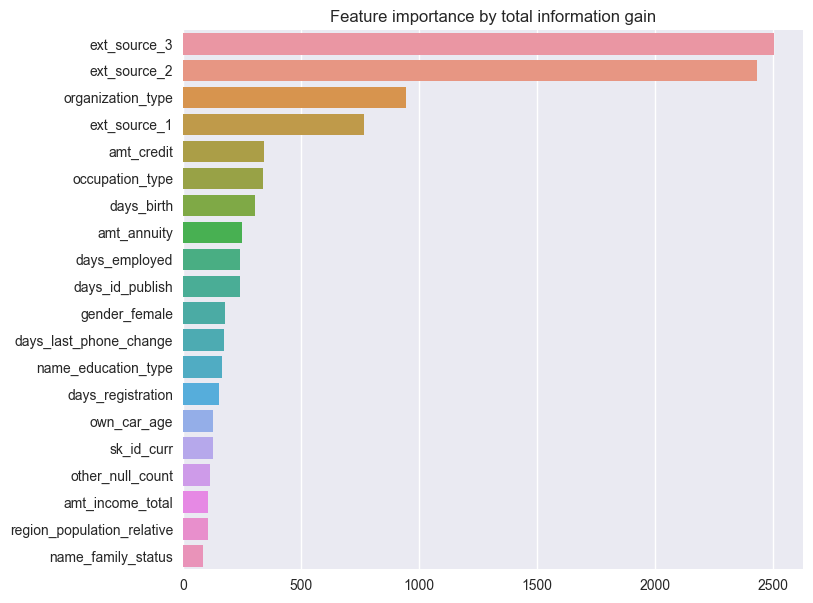

In [359]:
def plot_importances(X_train, model):
    labeled_fi = sorted( list(zip(X_train.columns, model.feature_importance(importance_type='gain'))), key=lambda x: -x[1])
    plt.figure(figsize=(8,7))
    x_imp = [tup[0] for tup in labeled_fi[:20]]
    y_labels = [tup[1] for tup in labeled_fi[:20]]
    sns.barplot(y_labels, x_imp)
    plt.title("Feature importance by total information gain")
    plt.show()
    
importances = [round(i) for i in lgbmc.feature_importance(importance_type='gain')]
plot_importances(X_num_train, lgbmc)

This makes sense: the previous evaluations from other sources (ext_source_3 etc.) are highly predictive; organization type and occupation type are important; the amount of the loan and the age of the applicant are important.  The only surprise here is that sk_id_curr made the top 20 -- apparently the method of assigning ID numbers is not fully arbitary.

I've taken two approaches here to engineer new features:
- <b>intuitive ideas</b>, e.g dividing annuity by total credit amount to generate the payment rate
- <b>polynomial features</b>, e.g. amt_annuity squared, derived from generating polynomial features from the 20 most important features, then running a new model, and examining the top 20 features of that model.

Polynomial feature testing didn't turn up anything that intuitive features didn't already capture, except for the `housing_per_income` feature below.  For that reason, and in the interest of space, I've excluded the implementation from this notebook.

The actual testing of these features was done with the utility function `test_feature`, which is detailed and heavily used later in this notebook when we get to more advanced boosting-style feature engineering (the function will actually be demonstrated on the `payment_rate` feature below).

In [18]:
def add_eng_cols(df, log=False):
    df['payment_rate'] = df.amt_annuity / df.amt_credit
    df['relative_annuity'] = df.amt_annuity / (df.amt_income_total + 1)  # +1 to avoid dividing by 0
    df['relative_payment_rate'] = df.payment_rate / (df.amt_income_total + 1)
    df['pct_days_employed'] = df.days_employed / (df.days_birth-21.1*365) # % of adulthood employed
    df['housing_per_income'] = df.housing_quality / df.amt_income_total
    df['ext_mean'] = df[['ext_source_1','ext_source_2','ext_source_3']].mean(axis=1)
    df['ext_std'] = df[['ext_source_1','ext_source_2','ext_source_3']].std(axis=1)
    df['income_per_dependent'] = df.amt_income_total / (1 + df.cnt_children)
    
    if log:
        # log transformations from the "examining the data" section
        df['amt_credit_log'] = df['amt_credit'].apply(np.log10)
        df['amt_income_total_log'] = df['amt_income_total'].apply(np.log10)
        # not actually very useful in empirical tests - but we'll weed out unimportant features later

    return df

In [19]:
apps_df = add_eng_cols(apps_df, log=True)
apps_small_df = add_eng_cols(apps_small_df)

In [20]:
apps_df.head()

,sk_id_curr,target,name_contract_type,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,...,payment_rate,relative_annuity,relative_payment_rate,pct_days_employed,housing_per_income,ext_mean,ext_std,income_per_dependent,amt_credit_log,amt_income_total_log
0,100002,1,Cash loans,False,True,0,202500.0,406597.5,24700.5,351000.0,...,0.060749,0.121977,2.999949e-07,0.037116,0.000027,0.161787,0.092026,202500.0,5.609165,5.306425
1,100003,0,Cash loans,False,False,0,270000.0,1293502.5,35698.5,1129500.0,...,0.027598,0.132216,1.022156e-07,0.048556,0.000029,0.466757,0.219895,270000.0,6.111767,5.431364
2,100004,0,Revolving loans,True,True,0,67500.0,135000.0,6750.0,135000.0,...,0.050000,0.099999,7.407298e-07,0.008412,0.000000,0.642739,0.122792,67500.0,5.130334,4.829304
3,100006,0,Cash loans,False,True,0,135000.0,312682.5,29686.5,297000.0,...,0.094941,0.219898,7.032641e-07,0.113793,0.000000,0.650442,NaN,135000.0,5.495104,5.130334
4,100007,0,Cash loans,False,True,0,121500.0,513000.0,21865.5,513000.0,...,0.042623,0.179961,3.508021e-07,0.109939,0.000000,0.322738,NaN,121500.0,5.710117,5.084576


# Table merges

The diagram below shows how I've fitted the seven data tables in the dataset together.  Below, we'll follow this diagram step by step: 
- merge data about previous applications
- split the merged previous applications data into the previous (most recent) application, the second most recent application, and one aggregated all-past-applications table
- merge data about previous applications with other loan vendors
- split that merged data into the previous (most recent) application, the second most recent application, and one aggregated all-past-applications table
- merge all of these tables with the main apps table to make the full dataset table

<img src="merge_diagram4.png", align=left>

<b>Our main strategy here</b> is to be entirely maximalist in feature generation.  Right after this, we'll run several lightGBM models to identify which features are useless and drop them.


The first thing we will need to do with these datasets is group them by current ID (`sk_id_curr`) so that we can perform joins etc.

## Previous Applications & associated

#### Includes: previous_application, POS_CASH_balance, instalments_balance, credit_card_balance

In [68]:
# LOAD AND CLEAN:
previous_df = pd.read_csv("previous_application.csv")
previous_df.columns = [str.lower(column) for column in previous_df.columns]

# fill accompanying person and downpayment appropriately
previous_df['name_type_suite'].fillna(value='Unaccompanied', inplace=True)

# convert Y/N to boolean
previous_df['flag_last_appl_per_contract'] = previous_df['flag_last_appl_per_contract']=='Y'

# drop three columns that are overwhelmingly null
previous_df.drop(['rate_down_payment',
                  'rate_interest_primary',
                  'rate_interest_privileged',
                  'name_cash_loan_purpose'], 
                 axis=1, inplace=True)
previous_df.head()

,sk_id_prev,sk_id_curr,name_contract_type,amt_annuity,amt_application,amt_credit,amt_down_payment,amt_goods_price,weekday_appr_process_start,hour_appr_process_start,...,name_seller_industry,cnt_payment,name_yield_group,product_combination,days_first_drawing,days_first_due,days_last_due_1st_version,days_last_due,days_termination,nflag_insured_on_approval
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


The previous applications datasheet contains 1.7 million previous loan applications by individuals who have current applications in the main spreadsheet.  Some quick stats:
- about 200,000 of the 300,000 applicants in our test sheet have past loans on record here
- the typical applicant in the previous applications sheet has four previous applications (median)

Let's take a quick look at two key distributions.  First, the number of applications per applicant:

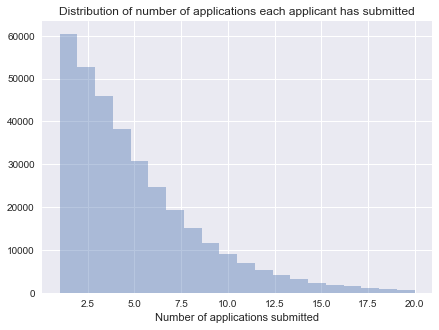

In [257]:
plt.figure(figsize=(7,5))
sns.distplot([val for val in previous_df.sk_id_curr.value_counts() if val <= 20], kde=False, bins=20)
plt.title('Distribution of number of applications each applicant has submitted')
plt.xlabel('Number of applications submitted')
plt.show()

We can see that this is a pretty basic Poisson distribution - and that a large majority of current applicants who applied previously applied more than once previously.

And let's look at the distribution of how long ago these applications were submitted:

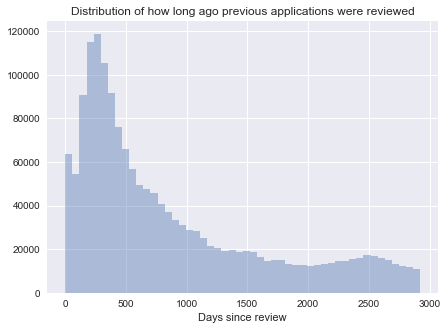

In [258]:
plt.figure(figsize=(7,5))
sns.distplot(previous_df.days_decision*-1, kde=False)
plt.title('Distribution of how long ago previous applications were reviewed')
plt.xlabel('Days since review')
plt.show()

This shows us that the typical previous application was about a year old, and that the records go back about nine years (hence the hard cutoff at the far right).

The main challenge of the "previous applications" table is that it has multiple entries for many loan applicants.  We'll deal with this in two stages.  First, we'll create a table `prev_df` of just the most recent ("previous") application by each applicant, since this will be the most important information.  Then, we'll create a second table `past_df` summarizing all other past applications by grouping by applicant and using three different ways of combining the applicant's values from these applications:
- for numerical columns, we'll just take the mean
- for most categorical columns, we'll take the most common entry
- for a few particularly important numerical columns, we'll one-hot encode them and then sum them

First, however, we'll need to process and incorporate our ancillary-ancillary tables that contain supplementary information about previous loans.

### Supplementary tables for previous applications

<b>The POS_CASH_balance table</b> will useful for getting average days late on loans.  Beyond that, the montly timestamps data isn't going to be much use unless we want to assemble some sort of time series.  (We could include the timestamp for the first late payment, but since 95% of loans didn't have any late payments at all, these timestamps would be overwhelmingly null.)

In [22]:
#load 
pcb_df = pd.read_csv("POS_CASH_balance.csv")
pcb_df.columns = [str.lower(column) for column in pcb_df.columns]

# some renaming for clarity:
pcb_df.rename(columns={
    'sk_dpd':'av_dpd_minor',
    'sk_dpd_def':'av_dpd_major' 
    }, inplace=True)

# rename name_contract_status to avoid confusion with previous_df column of same name:
# (not doing this creates an evil combinatorial-column-proliferation problem when groupby-ing the combined table)
pcb_df.rename(columns={'name_contract_status':'pcb_name_contract_status'}, inplace=True)

# compress pcb_df to one row per loan, compiling mean and var for days late
pcb_df = pcb_df[['sk_id_prev', 'av_dpd_minor', 'av_dpd_major','months_balance', 'pcb_name_contract_status']]
pcb_df = pcb_df[~pcb_df.pcb_name_contract_status.isin(['Canceled', 'XNA'])] # these 17 rows aren't worth 2 new dummy cols
pcb_df = pd.get_dummies(pcb_df, 'pcb_name_contract_status')
pcb_df = pcb_df.groupby('sk_id_prev', as_index=False).agg(['mean', 'max', 'var'])
# flatten multiindex
pcb_df.columns = ['_'.join(col) for col in pcb_df.columns]
pcb_df.reset_index(inplace=True)
pcb_df.head()

,sk_id_prev,av_dpd_minor_mean,av_dpd_minor_max,av_dpd_minor_var,av_dpd_major_mean,av_dpd_major_max,av_dpd_major_var,months_balance_mean,months_balance_max,months_balance_var,...,pcb_name_contract_status_Completed_var,pcb_name_contract_status_Demand_mean,pcb_name_contract_status_Demand_max,pcb_name_contract_status_Demand_var,pcb_name_contract_status_Returned to the store_mean,pcb_name_contract_status_Returned to the store_max,pcb_name_contract_status_Returned to the store_var,pcb_name_contract_status_Signed_mean,pcb_name_contract_status_Signed_max,pcb_name_contract_status_Signed_var
0,1000001,0.0,0,0.0,0.0,0,0.0,-9.0,-8,1.000000,...,0.333333,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0
1,1000002,0.0,0,0.0,0.0,0,0.0,-52.0,-50,2.500000,...,0.200000,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0
2,1000003,0.0,0,0.0,0.0,0,0.0,-2.5,-1,1.666667,...,0.000000,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0
3,1000004,0.0,0,0.0,0.0,0,0.0,-25.5,-22,6.000000,...,0.125000,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0
4,1000005,0.0,0,0.0,0.0,0,0.0,-51.0,-46,11.000000,...,0.090909,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0


<b>The install payments table</b> will yield some useful information on past payments such as average days late, percentage left unpaid, etc.

In [23]:
# load
install_payments_df = pd.read_csv('installments_payments.csv')
install_payments_df.columns = [str.lower(column) for column in install_payments_df.columns]

# create combination columns
install_payments_df['amt_unpaid'] = install_payments_df.amt_instalment - install_payments_df.amt_payment
install_payments_df['pct_unpaid'] = (install_payments_df.amt_instalment - install_payments_df.amt_payment) \
                                / install_payments_df.amt_instalment
install_payments_df['days_late'] = install_payments_df.days_entry_payment - install_payments_df.days_instalment

# drop columns we've incorporated into combination columns or otherwise don't have use for
install_payments_df.drop(['num_instalment_version', 
                          'amt_payment',
                          'days_entry_payment',
                          'sk_id_curr'], axis=1, inplace=True)

# group by loan
agg_funcs = {'num_instalment_number':'count',
            'days_instalment':['min', 'mean'],
            'pct_unpaid':['mean', 'max'],
             'amt_unpaid':['mean', 'var', 'max'],
            'days_late':['mean', 'max']}
install_payments_df = install_payments_df.groupby('sk_id_prev', as_index=False).agg(agg_funcs)
# flatten multiindex
install_payments_df.columns = ['_'.join(col) for col in install_payments_df.columns]
install_payments_df.rename(columns={'sk_id_prev_':'sk_id_prev'}, inplace=True)
install_payments_df.head()

,sk_id_prev,num_instalment_number_count,days_instalment_min,days_instalment_mean,pct_unpaid_mean,pct_unpaid_max,amt_unpaid_mean,amt_unpaid_var,amt_unpaid_max,days_late_mean,days_late_max
0,1000001,2,-268.0,-253.000000,0.000000,0.00000,0.000000,0.000000e+00,0.000,-16.000000,-6.0
1,1000002,4,-1600.0,-1555.000000,0.000000,0.00000,0.000000,0.000000e+00,0.000,-19.750000,-5.0
2,1000003,3,-94.0,-64.000000,0.000000,0.00000,0.000000,0.000000e+00,0.000,-15.333333,-14.0
3,1000004,7,-862.0,-772.000000,0.000000,0.00000,0.000000,0.000000e+00,0.000,-26.714286,-10.0
4,1000005,11,-1688.0,-1543.454545,0.090909,0.99981,1337.600455,1.967272e+07,14710.815,-8.454545,3.0


<b>The credit card balance table</b> includes a `sk_id_prev` flag like the other supplementary tables to the previous applications, but it's not totally clear how this relates to to the `sk_id_prev` element of the other tables here.  The description unhelpfully states that it contains "every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample" without giving any further specification of *how* it's related.

The best as I can figure, this is simply a list of credit card balances and payments during the periods of the different loans.  Given that the payments are associated with the time period of one specific previous loan, we should get more overall information if we group this with the other past application data.  

The problem with this method is that this table only includes entries for about 100K previous loans (about 7% of all previous loans).  Merging the full dataset with this will already result in a bunch of 93% null columns.  Merging it with the other ancillary tables before splitting them into previous and merged past table would result in twice the number of columns, each 96% null. The other factor to consider is that in over 99% of cases we have only one set of payments per current applicant, rather than multiple credit card payment records over the dates of multiple previous loans. And these payment records include the dates, which independently indicate with which previous loan the payments corresponded with.

Given all this, we'll just create one `cc_bal_df` table and merge it directly with our main dataset.

In [51]:
# load
cc_bal_df = pd.read_csv('credit_card_balance.csv')
cc_bal_df.columns = [str.lower(column) for column in cc_bal_df.columns]

# generate pcdt_unpaid column
cc_bal_df['pct_unpaid'] = (cc_bal_df.amt_balance - cc_bal_df.amt_payment_current) / (cc_bal_df.amt_balance + 1)

# drop sk_id_curr (we'll groupby and later join with sk_id_prev)
# cc_bal_df.drop('sk_id_curr', axis=1, inplace=True)

# these 22 rows out of 3 mil aren't worth 2 new dummy cols:
cc_bal_df = cc_bal_df[~cc_bal_df.name_contract_status.isin(['Refused', 'Approved'])]
cc_bal_df = pd.get_dummies(cc_bal_df, 'name_contract_status')

# because this dataset is pretty opaque, we're just going to take the mean and var of every column for each user
cc_bal_df = cc_bal_df.groupby('sk_id_prev', as_index=False).agg(['mean','var'])
cc_bal_df.columns = ['_'.join(col) for col in cc_bal_df.columns]
# but we don't need variance for the binary dummy columns, or for sk_id_curr:
cc_bal_df.drop(['name_contract_status_Active_var',
                'name_contract_status_Completed_var',
                'name_contract_status_Demand_var',
                'name_contract_status_Sent proposal_var',
                'name_contract_status_Signed_var',
                'sk_id_curr_var'], axis=1, inplace=True)
cc_bal_df.rename(columns={'sk_id_curr_mean':'sk_id_curr'}, inplace=True)
cc_bal_df.reset_index(inplace=True) # because for some reason pandas ignores the as_index=False option above

# cc_bal_df.sk_id_prev.nunique() is 104,307
# cc_bal_df.sk_id_curr.nunique() is 103,558
# therefore grouping by sk_id_curr will only collapse less than 1% of the rows.  We'll just take a simple mean.
cc_bal_df = cc_bal_df.groupby('sk_id_curr', as_index=False).agg('mean')

In [263]:
cc_bal_df.shape

(103558, 49)

#### Now we'll join our ancillary tables onto our full previous_applications table 
(omitting `cc_bal_df` because of the reasons described above)

In [25]:
all_previous_df = previous_df.merge(
    pcb_df, on='sk_id_prev', how='left').merge(
    install_payments_df, on='sk_id_prev', how='left')

In [265]:
all_previous_df.head()

,sk_id_prev,sk_id_curr,name_contract_type,amt_annuity,amt_application,amt_credit,amt_down_payment,amt_goods_price,weekday_appr_process_start,hour_appr_process_start,...,pcb_name_contract_status_Demand,pcb_name_contract_status_Returned to the store,pcb_name_contract_status_Signed,num_instalment_number_count,days_instalment_min,days_instalment_max,pct_unpaid_mean,pct_unpaid_max,days_late_mean,days_late_max
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,0.0,0.0,0.0,1.0,-42.0,-42.0,0.0,0.0,0.000000,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,0.0,607500.0,THURSDAY,11,...,0.0,0.0,0.0,5.0,-134.0,-14.0,0.0,0.0,-9.200000,-7.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,0.0,112500.0,TUESDAY,11,...,0.0,0.0,0.0,9.0,-271.0,-31.0,0.0,0.0,-8.222222,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,0.0,450000.0,MONDAY,7,...,0.0,0.0,0.0,11.0,-482.0,-182.0,0.0,0.0,-7.090909,0.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,0.0,337500.0,THURSDAY,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Finally, we'll execute our strategy for splitting the data into one table of just the most recent loan, and one table of all the other past loans.

In [55]:
# define utility functions for splitting prev (most recent) vs past and grouping past applications by applicant
def split_past_prev(df, time_col, past_id, prev_suffix=None):
    '''
    time_col = column that contains days since application
    past_id = column that contains id of the loan represented by the row
    '''    
    start = time()
    df = df.sort_values(by=['sk_id_curr', time_col]) # each group sorted by days_decision so most recent is last
    prev_df = df.groupby('sk_id_curr').nth(-1) # selects last entry from each group
    past_df = df[~df[past_id].isin(prev_df[past_id])] # selects all entries not in previous_df
    prev_df.reset_index(inplace=True)
    if prev_suffix:
        prev_df.columns = [col + prev_suffix for col in prev_df.columns]
    prev_df.rename(columns={('sk_id_curr'+prev_suffix):'sk_id_curr'}, inplace=True)
    print("Elapsed time (minutes):", round((time()-start)/60, 1))
    return (past_df, prev_df)

def categorical_mode(series):
    if series.count() == 0:
        return float('NaN')
    else:
        return series.mode()[0]

def group_apps(df, count_col, cats_to_encode=[], summary_suffix=None):
    start = time()
    
    # eliminate spaces from column names:
    df.columns = [col.replace(' ', '_') for col in df.columns]      
    
    cat_cols = []
    for col in df.columns:
        if df.dtypes[col] == 'object' and col not in cats_to_encode:
            cat_cols.append(col)
    num_cols = [col for col in df.columns if col not in (cat_cols + cats_to_encode + ['sk_id_curr'])]
    
    df['target'] = y # NOTE: sloppy addition - if re-using, note that y should be passed in
    for col in cats_to_encode:
        df[col + '_target_mean'] = target_mean_encode(col, 'target', df)
        df[col + '_target_std'] = target_std_encode(col, 'target', df)
    
    df = pd.get_dummies(df, columns=cats_to_encode)
    # eliminate spaces from column names:
    df.columns = [col.replace(' ', '_') for col in df.columns]
    dummy_cols = [col for col in df.columns if col not in (
        num_cols + cat_cols + cats_to_encode + ['target', 'sk_id_curr'])]
    
    agg_funcs = {}
    for col in dummy_cols:
        agg_funcs[col] = ['mean', 'var', 'sum']
    for col in num_cols:
        agg_funcs[col] = ['min', 'max', 'mean', 'var']  # alternative: ['mean', 'var']
    for col in cat_cols:
        agg_funcs[col] = [categorical_mode, 'nunique']
        # categorical_mode = custom function defined above; target_mean_encode defined higher up
    agg_funcs[count_col] = 'count'  # we'll rename this prev_app_count below
    
    print("Performing groupby...")
    grouped_df = df.groupby('sk_id_curr').agg(agg_funcs)  # NOTE: takes a while
    grouped_df.rename(columns={count_col:'prev_app_count'}, inplace=True)
    grouped_df.reset_index(inplace=True)
    
    # collapse multi-index
    grouped_df.columns = ['_'.join(col) for col in grouped_df.columns]
    
    # add suffix to all columns (to avoid duplicates later)
    if summary_suffix:
        grouped_df.columns = [col + summary_suffix for col in grouped_df.columns]
        # remove suffix from sk_id_curr - we need it for merging
        grouped_df.rename(columns={('sk_id_curr'+summary_suffix):'sk_id_curr'}, inplace=True)

    print("Elapsed time (minutes):", round((time()-start)/60, 1))
    return grouped_df

In [46]:
# pull prev_1 from past; save restOfPast
other_past1_df, prev1_df = split_past_prev(all_previous_df, 
                                   time_col='days_decision', 
                                   past_id='sk_id_prev',
                                   prev_suffix='_prev1')

# pull prev_2 from restOfPast
other_past2_df, prev2_df = split_past_prev(other_past1_df, 
                                   time_col='days_decision', 
                                   past_id='sk_id_prev',
                                   prev_suffix='_prev2')

# do maximalist summary of all data (including first two)
past_summary_df = group_apps(all_previous_df, 
                     count_col='sk_id_prev', 
                     cats_to_encode=['name_contract_type','name_contract_status','name_payment_type'],
                     summary_suffix='_prev_summ')

Elapsed time (minutes): 0.3
Elapsed time (minutes): 0.1
Performing groupby...
Elapsed time (minutes): 19.9


In [ ]:
# quick garbage collection cleanup to keep our kernel manageable
del previous_df, all_previous_df, pcb_df, install_payments_df

## Bureau & bureau balance

The Bureau dataframe is like the previous applications table, except that it contains previous applications with other financial institutions, and the information about those applications recorded in the columns is a bit different.  We'll treat it in exactly the same way we treated the previous applications table: split it into one most-recent-app table, and one aggregated all-other-past-apps table.

First, however, we'll need to join the data from the `bureau balance` table.  The bureau balance table contains as distinct rows the monthly loan status for each month for each previous loan with other institutions.  This only contains the loan IDs, and not the current applicant IDs.  We'll consolidate the rows such that each row represents one previous loan.  Then we'll join this table to the main Bureau table, since they're effectively just a couple more stats for each loan.  Specifically, these stats represent how many months each loan spent with which loan status.

In [47]:
bureau_df = pd.read_csv('bureau.csv')
bureau_df.columns = [str.lower(column) for column in bureau_df.columns]
bureau_df.head()

,sk_id_curr,sk_id_bureau,credit_active,credit_currency,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,credit_type,days_credit_update,amt_annuity
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [48]:
# load
bureau_balance_df = pd.read_csv('bureau_balance.csv')
bureau_balance_df.columns = [str.lower(column) for column in bureau_balance_df.columns]
# NOTE: there are only two columns that are over half null, and they're both around 70% and important enough to keep

# drop not-so-useful column
bureau_balance_df.drop('months_balance', axis=1, inplace=True)
# generate dummies for the main categorical var for groupby-ing down to one entry per loan
bureau_balance_df = pd.get_dummies(bureau_balance_df, 'status')
# groupby and generate a total months column:
bureau_balance_df = bureau_balance_df.groupby('sk_id_bureau', as_index=False).agg(['mean','sum'])
bureau_balance_df['total_months'] = bureau_balance_df[bureau_balance_df.columns[1:]].sum(axis=1)
bureau_balance_df.columns = ['_'.join(col) for col in bureau_balance_df.columns]
bureau_balance_df.reset_index(inplace=True)
bureau_balance_df.head()

,sk_id_bureau,status_0_mean,status_0_sum,status_1_mean,status_1_sum,status_2_mean,status_2_sum,status_3_mean,status_3_sum,status_4_mean,status_4_sum,status_5_mean,status_5_sum,status_C_mean,status_C_sum,status_X_mean,status_X_sum,total_months_
0,5001709,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.886598,86,0.113402,11,98.000000
1,5001710,0.060241,5,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.578313,48,0.361446,30,83.939759
2,5001711,0.750000,3,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.250000,1,4.250000
3,5001712,0.526316,10,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.473684,9,0.000000,0,19.473684
4,5001713,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,1.000000,22,23.000000


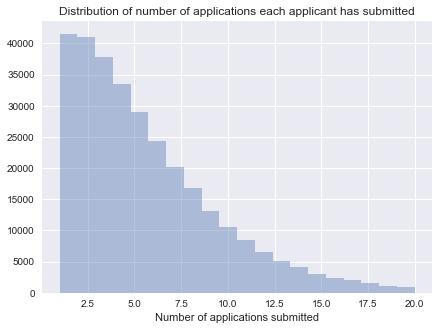

In [281]:
plt.figure(figsize=(7,5))
sns.distplot([val for val in bureau_df.sk_id_curr.value_counts() if val <= 20], kde=False, bins=20)
plt.title('Distribution of number of applications each applicant has submitted')
plt.xlabel('Number of applications submitted')
plt.show()

To confirm: the distribution of the number of previous applications an applicant has submitted is comparable to that distribution for the previous_applications table (albeit the total number of applicants represented is about 30% less, so about half of our total applicants in the main apps_df table).

In [49]:
all_bureau_df = pd.merge(bureau_df, bureau_balance_df, on='sk_id_bureau', how='left')

In [56]:
# pull prev_1 from past; save restOfPast
other_past_bureau1_df, prev_bureau1_df = split_past_prev(all_bureau_df, 
                                                       time_col='days_credit', 
                                                       past_id='sk_id_bureau',
                                                       prev_suffix='_bureau_p1')

# pull prev_2 from restOfPast
other_past_bureau2_df, prev_bureau2_df = split_past_prev(other_past_bureau1_df, 
                                                       time_col='days_credit', 
                                                       past_id='sk_id_bureau',
                                                       prev_suffix='_bureau_p2')

# do maximalist summary of all data (including first two)
bureau_summary_df = group_apps(bureau_df, 
                             count_col='sk_id_bureau', 
                             cats_to_encode=['credit_active'],
                             summary_suffix='_bureau_summ')

Elapsed time (minutes): 0.1
Elapsed time (minutes): 0.0
Performing groupby...
Elapsed time (minutes): 3.2


In [284]:
# quick cleanup to keep our kernel manageable
del bureau_df, bureau_balance_df, all_bureau_df, other_past_bureau1_df, other_past_bureau2_df

# Final data review and compilation
To review, our operative data tables now consist of:
- <b>`apps_df`:</b> our main apps data, complete with
- <b>`apps_small_df`:</b> a condensed and null-less version of the main apps table
- <b>`prev_df`:</b> data from each applicant's previous application, if the applicant has any on record
- <b>`past_df`:</b> data from each applicant's other past applications, if the applicant has any on record
- <b>`prev_bureau_df`:</b> data from each applicant's previous application with other agencies, if the applicant has any on record
- <b>`past_bureau_df`:</b> data from each applicant's other past applications with other agencies, if the applicant has any on record
- <b>`cc_bal_df`:</b> past credit card data for a small subset (<5%) of applicants

We'll now merge our main apps_df sheet with the past and prev tables to get our full, all-inclusive dataset.


In [76]:
start = time()
full_dataset_df = apps_df.merge(
    prev1_df, on="sk_id_curr", how="left").merge(
    prev2_df, on="sk_id_curr", how="left").merge(
    past_summary_df, on="sk_id_curr", how="left").merge(
    prev_bureau1_df.reset_index(), on="sk_id_curr", how="left").merge(
    prev_bureau2_df.reset_index(), on="sk_id_curr", how="left").merge(
    bureau_summary_df.reset_index(), on="sk_id_curr", how="left").merge(
    cc_bal_df.reset_index(), on="sk_id_curr", how="left")
    
print(round(((time()-start)/60), 2), "minutes")

0.87 minutes


In [79]:
full_dataset_df.to_csv('full_dataset2.csv')

In [84]:
# quick garbage collection cleanup to keep our kernel manageable
del prev_bureau1_df, prev_bureau2_df, past_summary_df, bureau_summary_df, prev1_df, prev2_df, cc_bal_df

## Elimination of unimportant features

We'll eliminate some unimportant features here.  We'll focus only on non-categorical features since it's difficult to trace the importance for multiple dummy-columns generated from the same categorical column, and GLRM will handle our categoricals directly.  

First, we'll run a couple different tree-based models.  Then we'll see which features had two or fewer splits across three different models (important features have hundreds).  We'll drop these features and re-test our model.

In [125]:
full_dummy_df = pd.get_dummies(full_dataset_df.drop(['target', 'sk_id_curr'], axis=1), dummy_na=True)
# remove any lingering sk_id columns, which may contribute to overfitting
full_dummy_df.drop([col for col in full_dummy_df.columns if 'sk_id' in col], axis=1, inplace=True)

In [127]:
def pare_features(X_set, y=y, importance_threshold=0.5, models=None, return_importances=False):
    '''Returns version of X_set with only features with greater av importance than
    the user-secified importance_threshold'''
    
    # default params with extra trees
    basic_params = {          
        'class_weight':'balanced',
        'n_estimators': 400
    }
    
    # params produced by a basic hyperparameter sweep later in this notebook
    best_params = {    
        'class_weight':'balanced',
        'reg_lambda': 1, 
        'reg_alpha': 2, 
        'random_state': 11, 
        'num_leaves': 14, 
        'n_estimators': 300, 
        'min_samples_split': 2, 
        'min_data_in_leaf': 1200, 
        'boosting_type': 'goss'
    }
    
    # params taken almost verbatim from a public kernel (explained later in this notebook)
    kernel_params_reduced = {
        'class_weight':'balanced',
        'n_estimators':500,  # reduced in the interest of processing time
        'learning_rate':0.02,
        'num_leaves':15,
        'colsample_bytree':0.95,
        'subsample':0.85,
        'max_depth':8,
        'reg_alpha':0.04,
        'reg_lambda':0.073,
        'min_split_gain':0.022,
        'min_child_weight':60,
        'metric':'auc'
    }
    
    start = time()
    
    X_train, X_test, y_train, y_test = train_test_split(X_set, y, test_size=1/3)
    
    if not models:
        lgbmc1 = LGBMClassifier(**basic_params) 
        lgbmc2 = LGBMClassifier(**best_params)
        lgbmc3 = LGBMClassifier(**kernel_params_reduced)
        models = [lgbmc1, lgbmc2, lgbmc3]
    
    all_importances = []
    
    for model in models:
        # fit model
        model.fit(X_train, y_train)
        # score and print to confirm everything works:
        y_test_proba = model.predict_proba(X_test)[:,1]
        test_auroc = round(roc_auc_score(y_test, y_test_proba), 3) 
        print("  Test AUROC {}: {}".format(models.index(model), test_auroc))
        # record model importances
        all_importances.append(model.feature_importances_)
    
    # compile averages and important columns:
    av_importances = np.mean(all_importances, axis=0)
    labeled_av_importances = list(zip(X_set.columns, av_importances))
    important_columns = [tup[0] for tup in labeled_av_importances if tup[1] >= importance_threshold]

    print("Reduced dataset from {} features to {} features".format(
        X_set.shape[1], len(important_columns)
    ))
    print("elapsed time:", round((time()-start)/60, 1), 'minutes')
    
    if return_importances:
        return X_set[important_columns], labeled_av_importances
    else:
        return X_set[important_columns]  

In [128]:
pared_df, av_importances = pare_features(full_dummy_df, y, importance_threshold=0.5, return_importances=True)

  Test AUROC 0: 0.779
  Test AUROC 1: 0.788
  Test AUROC 2: 0.783
Reduced dataset from 1324 features to 690 features
elapsed time: 15.4 minutes


In [108]:
more_pared_df = pare_features(full_dummy_df, y, importance_threshold=3)

  Test AUROC 0: 0.781
  Test AUROC 1: 0.788
  Test AUROC 2: 0.783
Reduced dataset from 1330 features to 400 features
elapsed time: 14.0 minutes


Finally, just to double-check, let's take a look at the features that we've dropped and check their predictive power on their own:

In [142]:
# train model on only the useless features:
dropped_cols = [col for col in full_dummy_df if col not in pared_df]
lgbmc2 = LGBMClassifier(**best_params)
quick_test_model(lgbmc2, full_dummy_df[dropped_cols], y)

  train AUROC: 0.714
  test AUROC: 0.67
  train f1-score: 0.239
  test f1-score: 0.214
elapsed time: 1.0 minutes


So there is at least *some* latent information about the target variable in these unused features, but not a lot.  Let's see which of them is proving helpful:

In [147]:
labeled_fi = sorted( list(zip(dropped_cols, lgbmc2.feature_importances_)), key=lambda x: -x[1])
labeled_fi[:15]

[('days_decision_max_prev_summ', 408),
 ('credit_active_target_std_mean_bureau_summ', 269),
 ('amt_income_total_log', 249),
 ('amt_total_receivable_mean', 185),
 ('name_payment_type_target_std_mean_prev_summ', 155),
 ('amt_total_receivable_var', 151),
 ('pcb_name_contract_status_Signed_var_mean_prev_summ', 108),
 ('housing_null_count', 84),
 ('av_dpd_minor_var_prev1', 60),
 ('pcb_name_contract_status_Completed_max_min_prev_summ', 43),
 ('days_first_drawing_prev1', 42),
 ('name_contract_status_target_mean_max_prev_summ', 38),
 ('status_1_sum_bureau_p1', 37),
 ('name_income_type_Pensioner', 37),
 ('name_contract_type_Revolving loans', 35)]

The usage is pretty heavily concentrated in the top few features here.  We'll add the top eight back in (down to `housing_null_count`).

In [148]:
pd.options.mode.chained_assignment = None  # default='warn'

for col in [tup[0] for tup in labeled_fi[:8]]:
    pared_df[col] = full_dummy_df[col].copy()

And we'll save this dataset as a csv here for easier reloading.

In [149]:
pared_df.shape

(307508, 701)

In [150]:
pared_df.to_csv('pared_df.csv')

## Data reload:

This is a purely procedural section to reload the data without running the entire section above, and can be ignored. 

In [210]:
# MAIN:
# full_dataset_df = pd.read_csv('full_dataset2.csv', index_col=0)
# full_dummy_df = pd.get_dummies(full_dataset_df.drop('target', axis=1))
# pared_df = pd.read_csv('pared_df.csv', index_col=0)
# glrm_df = pd.read_csv('glrm_imp30.csv', index_col=0)
# glrm_vis_df = pd.read_csv('glrm_vis_df.csv', index_col=0)

# COMPONENT:
# apps_df = pd.read_csv('apps_df.csv', index_col=0)
# apps_small_df = pd.read_csv('apps_small_df.csv', index_col=0)
# prev_df = pd.read_csv('prev_df.csv', index_col=0)
# past_df = pd.read_csv('past_df.csv', index_col=0)
# prev_bureau_df = pd.read_csv('prev_bureau_df.csv')
# past_bureau_df = pd.read_csv('past_bureau_df.csv')
# cc_bal_df = pd.read_csv('cc_bal_df.csv', index_col=0)

# RESULTS:
# cluster_labels = pd.read_csv('cluster_labels.csv', index_col=0)
# lof_preds = pd.read_csv('lof_pred.csv', index_col=0)

# TARGET:
# y = apps_small_df.target
# target_col = full_dataset_df['target']
# del full_dataset_df

# Feature reduction: GLRM

None of the sklearn algorithms we'll want to use allow for null values, so we'll want to have some sort of imputing. It would be ideal for information retention to use an accurate imputation method and maintain the full dataset.  However, the advanced imputation methods in python (chiefly contained in the fancyimpute package) are buggy and don't scale well.

Because we have many features, we may also want a feature reduction algorithm to allow for more complex algorithms that would be unfeasible on a 200+ feature dataset with 300,000 examples.  This algorithm should ideally be able to handle different types of data, including numerical, binary, and categorical.

Probably the best single algorithm that can fulfill all of these needs is Generalized Low-Rank Models.  GLRM uses alternating minimization with customizable-by-column cost functions to allow for a PCA- or NNMF-like matrix factorization across various data types.  The reduced dataset is null-less and lower-rank than the original.  We'll try this here with the number of reduced features set to 30.

In [216]:
null_pcts = (full_dataset_df.isnull().sum() / full_dataset_df.shape[0]).round(2)
print("TOTAL NULL PERCENTAGE:", round(null_pcts.mean(), 2), "\n")
print("NULL RATIOS FOR COLUMNS WHERE NULLS >= 50%:")
print(null_pcts[null_pcts >= .5].sort_values(ascending=False))

TOTAL NULL PERCENTAGE: 0.22 

NULL RATIOS FOR COLUMNS WHERE NULLS >= 50%:
amt_annuity_y.1                         0.81
amt_annuity                             0.77
days_enddate_fact_x                     0.75
total_months_y                          0.74
status_C_y                              0.74
status_1_y                              0.74
status_0_y                              0.74
status_X_y                              0.74
total_months_x                          0.70
status_X_x                              0.70
status_C_x                              0.70
status_0_x                              0.70
fondkapremont_mode                      0.68
amt_credit_max_overdue_x                0.67
housing_age                             0.66
own_car_age                             0.66
ext_combined                            0.64
ext_source_1                            0.56
wallsmaterial_mode                      0.51
pcb_name_contract_status_Completed_x    0.50
pcb_name_contract_status_A

We can see from the list above that we have a lot of nulls.  However, GLRM can typically handle up to 90% nulls, so this isn't a deal-breaker.

The other factor to consider here is that the more features present, the larger the error per feature.  Because of this, the best GLRM-reduced dataset for our purposes will only include features that have some significant role in predicting our target variable.  There is some optimal pairing of `i` = num_top_features_for_reduction and `k` = num_GLRM_features for predictive accuracy.  The computational expense is too great to do a proper parameter sweep for the operation, but after several trials I've settled on using our 40 most important features for the lightGBM model and reduce those to 30 null-less columns.

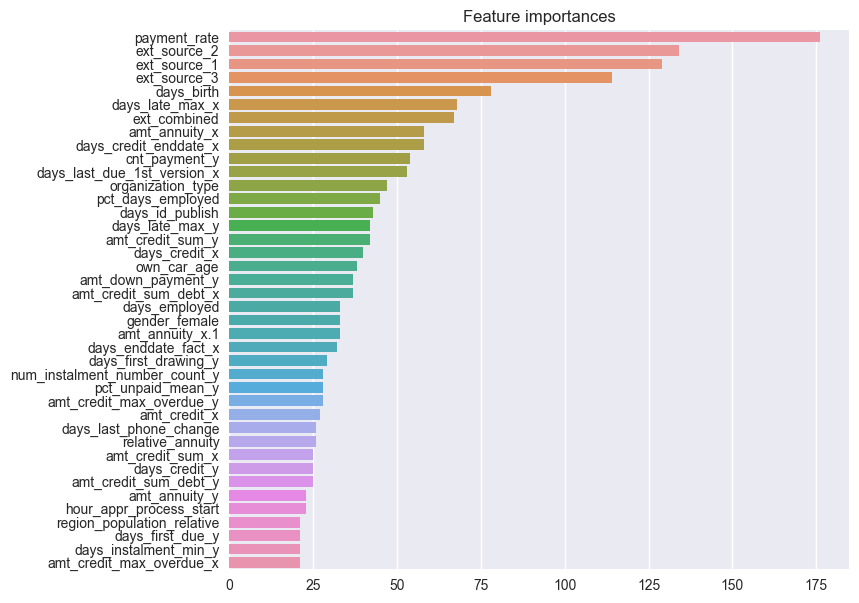

In [487]:
def plot_importances2(X_train, importances):
    labeled_fi = sorted( list(zip(X_train.columns, importances)), key=lambda x: -x[1])
    plt.figure(figsize=(8,7))
    x_imp = [tup[0] for tup in labeled_fi[:40]]
    y_labels = [tup[1] for tup in labeled_fi[:40]]
    sns.barplot(y_labels, x_imp)
    plt.title("Feature importances")
    plt.show()
    
importances = [round(i) for i in lgbmc.feature_importances_]
plot_importances2(full_dummy_df, importances)

In [511]:
labeled_fi = sorted( list(zip(full_dummy_df.columns, importances)), key=lambda x: -x[1])
top_37_features = [tup[0] for tup in labeled_fi[:37]]
# add three most important categorical features
top_40_features = top_37_features + ['occupation_type', 'name_education_type', 'name_family_status']
top_40_features

['payment_rate',
 'ext_source_2',
 'ext_source_1',
 'ext_source_3',
 'days_birth',
 'days_late_max_x',
 'ext_combined',
 'amt_annuity_x',
 'days_credit_enddate_x',
 'cnt_payment_y',
 'days_last_due_1st_version_x',
 'organization_type',
 'pct_days_employed',
 'days_id_publish',
 'days_late_max_y',
 'amt_credit_sum_y',
 'days_credit_x',
 'own_car_age',
 'amt_down_payment_y',
 'amt_credit_sum_debt_x',
 'days_employed',
 'gender_female',
 'amt_annuity_x.1',
 'days_enddate_fact_x',
 'days_first_drawing_y',
 'num_instalment_number_count_y',
 'pct_unpaid_mean_y',
 'amt_credit_max_overdue_y',
 'amt_credit_x',
 'days_last_phone_change',
 'relative_annuity',
 'amt_credit_sum_x',
 'days_credit_y',
 'amt_credit_sum_debt_y',
 'amt_annuity_y',
 'hour_appr_process_start',
 'region_population_relative',
 'occupation_type',
 'name_education_type',
 'name_family_status']

In [507]:
glrm_coltypes_small = glrm_column_types.copy()
for key in glrm_column_types.keys():
    if key not in top_40_features:
        del glrm_coltypes_small[key]
len(glrm_coltypes_small)

40

In [ ]:
glrmodel_imp30 = H2OGeneralizedLowRankEstimator(
                                       k=30,
                                       seed=11,
                                       transform="STANDARDIZE",
                                       regularization_x="None", 
                                       regularization_y="None",
                                       init='SVD',
                                       max_iterations=30, 
                                       multi_loss='categorical',
                                       #loss_by_col=[loss_by_col[c] for c in khous_run.columns], 
                                       impute_original=True)

In [523]:
start = time()
glrmodel_imp30.train(training_frame=imp_h2)
print('elapsed time:', round((time()-start)/60, 1), "minutes")

glrm Model Build progress: |██████████████████████████████████████████████| 100%
elapsed time: 9.6 minutes


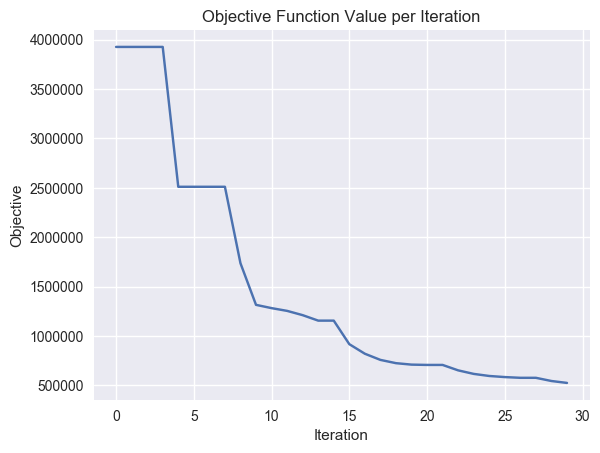

In [524]:
model_score = glrmodel_imp30.score_history()
plt.xlabel("Iteration")
plt.ylabel("Objective")
plt.title("Objective Function Value per Iteration")
plt.plot(model_score["iterations"], model_score["objective"])
plt.show()

In [525]:
model = glrmodel_imp30._model_json
model_out = model['output']
# num_archs = glrmodel_5.params['k']['actual']
archs_df = model_out["archetypes"].as_data_frame()
archs = np.array(archs_df)
X = h2o.get_frame(model_out['representation_name'])
glrm_imp30_df = X.as_data_frame()

print('Projected shape:', glrm_imp30_df.shape)

Projected shape: (307508, 30)


Using these thirty features, our model is able to achieve a test AUROC of about 0.75.

In [526]:
lgbmc_glrm = LGBMClassifier(class_weight='balanced')
quick_test_model(lgbmc_glrm, glrm_imp30_df, y)

  train AUROC: 0.798
  test AUROC: 0.748
  train f1-score: 0.289
  test f1-score: 0.265
elapsed time: 0.4 minutes


For comparison, our full dataset achieves about 0.785.  This dropoff is significant, but the reduced featureset does capture most of the predictive power of the full dataset.

In [485]:
lgbmc = LGBMClassifier(class_weight='balanced')
quick_test_model(lgbmc, full_dummy_df, y)

  train AUROC: 0.83
  test AUROC: 0.785
  train f1-score: 0.324
  test f1-score: 0.29
elapsed time: 1.4 minutes


# Boosting from other models

One other trick that may gain us a little accuracy is running anomaly detection algorithms or non-tree-based predictors and using the output as a feature in our dataset.  This is where the smaller, null-less GLRM dataset we just produced will come in handy, since we can use it for any sklearn algorithm.  We'll try several of these here, and see whether adding the feature increases our scores.  Specifically, we'll try:

<b>Clustering algorithms:</b>
- KNN clustering
- HDBSCAN (Hierarchical DBSCAN)

<b>Anomaly detection algorithms:</b>
- Isolation Forest
- Local Outlier Factor

<b>Non-tree-based predictors:</b>
- Gaussian Naive Bayes

We'll add the output of each of these algorithms to our dataset as additional features, and see if they boost our accuracy at all.  Two additional notes about the execution of these tests:
- the utility function below prints out the increases as z-scores, that is, as fractions of the standard deviation of the base model.  A 0.67 z-score means there's a 50% chance the gain is significant; a 1.96 z-score means there's a 95% chance.
- this utility function tests to see whether the feature improves on the performance of a model trained on glrm_df. A feature that improves in this will not *necessarily* improve on our full dataset -- but if it doesn't help here, it certainly won't help on the full set.  Passing this test is necessary but not sufficient.
- Most of the models used for boosting cannot handle nulls directly, so we'll only be able to test them on the GLRM-reduced dataset (0.748 LGBM AUROC score) or on the X_sm_encoded dataset (LGBM 0.752), not the full dataset.

In [154]:
# define utility function for testing new features

def test_feature(feature, X_df=glrm_df, y_set=y, reps=4):
    start = time()
    
    if type(feature) == np.ndarray:
        feature = pd.DataFrame(feature)
    
    # reset_index pre-empts index errors:
    X_new = pd.concat([X_df.reset_index(drop=True), feature], axis=1)
    
    test_aurocs = {'base':[], 'new':[], 'name': 'Test AUROC'}
    train_aurocs = {'base':[], 'new':[], 'name': 'Train AUROC'}
    test_f1s = {'base':[], 'new':[], 'name': 'Test f1-score'}
    train_f1s = {'base':[], 'new':[], 'name': 'Train f1-score'}
    
    # splt data, fit models, generate scores
    for rep in range(reps):
        # create models
        base_model = LGBMClassifier(class_weight='balanced')
        new_model = LGBMClassifier(class_weight='balanced')
        
        # split data
        X_train_new, X_test_new, y_train, y_test = train_test_split(X_new, y_set, test_size=1/3)
        # separate original data on the same split:
        X_train = X_train_new[X_df.columns]
        X_test = X_test_new[X_df.columns]
        
        base_model.fit(X_train, y_train)
        y_train_proba = base_model.predict_proba(X_train)[:,1]
        y_test_proba = base_model.predict_proba(X_test)[:,1]
        y_pred_train = base_model.predict(X_train)
        y_pred_test = base_model.predict(X_test)     
        test_aurocs['base'].append(roc_auc_score(y_test, y_test_proba))
        train_aurocs['base'].append(roc_auc_score(y_train, y_train_proba))
        test_f1s['base'].append(f1_score(y_test, y_pred_test))
        train_f1s['base'].append(f1_score(y_train, y_pred_train))
        
        new_model.fit(X_train_new, y_train)
        y_train_proba = new_model.predict_proba(X_train_new)[:,1]
        y_test_proba = new_model.predict_proba(X_test_new)[:,1]
        y_pred_train = new_model.predict(X_train_new)
        y_pred_test = new_model.predict(X_test_new)     
        test_aurocs['new'].append(roc_auc_score(y_test, y_test_proba))
        train_aurocs['new'].append(roc_auc_score(y_train, y_train_proba))
        test_f1s['new'].append(f1_score(y_test, y_pred_test))
        train_f1s['new'].append(f1_score(y_train, y_pred_train))
    
    # calculate z-scores and print
    for score in [train_aurocs, test_aurocs, train_f1s, test_f1s]:
        score['gains'] =  [score['new'][i] - score['base'][i] for i in range(reps)]
        score['mean_gain_zscore'] = np.mean(score['gains']) / np.std(score['base'])
        print(score['name'], 'mean gain as z-score:', round(score['mean_gain_zscore'],2))
        
    print("  (elapsed time:", round((time()-start)/60, 1), 'minutes)')

As an initial test, we'll try running this function to whether adding our most significant engineered feature to the glrm dataset increases the model score (it should – significantly):

In [155]:
test_feature(pared_df.payment_rate)

Train AUROC mean gain as z-score: 6.12
Test AUROC mean gain as z-score: 4.85
Train f1-score mean gain as z-score: 8.18
Test f1-score mean gain as z-score: 6.12
  (elapsed time: 1.1 minutes)


Good - that's what we'd expect.

Finally, let's create a dataframe for useful boosting-generated features to add:

In [201]:
boost_additions_df = pd.DataFrame()

## Clustering algorithms


### KNN Clustering

For KNN clustering, we'll first plot inertia (distortion) for various values of k to look for an elbow point at an optimal value of k.  Then we'll produce our boosting data with that k-value.  To account for the randomness inherent to randomly seeded k-value clustering, especially a mini-batch version, we'll do two tests of each k-value to confirm that our results are consistent.

Note that we'll be using our feature-reduced and imputed `glrm_df` dataframe for our clustering.  This dataset is already normalized, so there's no need for pre-processing before clustering.


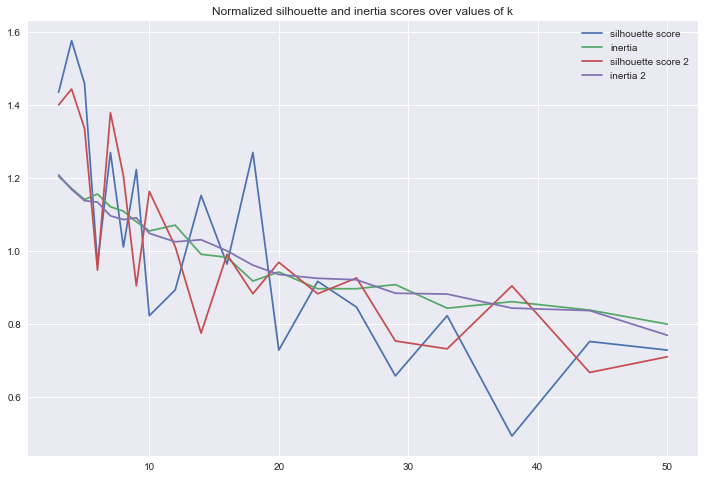

  (elapsed time: 3.7 minutes)


In [159]:
from sklearn.metrics import adjusted_rand_score, silhouette_score, silhouette_samples
from sklearn.cluster import MiniBatchKMeans
start = time()

k_vals = [3,4,5,6,7,8,9,10,12,14,16,18,20,23,26,29,33,38,44,50]
inertias = []
silhouettes = []
for k in k_vals:
    mbk = MiniBatchKMeans(n_clusters=k, batch_size=50000)
    cluster_labels = mbk.fit(glrm_df)
    inertias.append(mbk.inertia_)
    # use only about 4K examples (every 70th) since silhouette scoring has quadratic growth rate and overloads RAM
    silhouette = round(silhouette_score(glrm_df[::70], mbk.labels_[::70]), 3)
    silhouettes.append(silhouette)
    
inertias2 = []
silhouettes2 = []
for k in k_vals:
    mbk = MiniBatchKMeans(n_clusters=k, batch_size=20000)
    cluster_labels = mbk.fit(glrm_df)
    inertias2.append(mbk.inertia_)
    # use only about 4K examples (every 79th) since silhouette scoring has quadratic growth rate and overloads RAM
    silhouette = round(silhouette_score(glrm_df[::79], mbk.labels_[::79]), 3)
    silhouettes2.append(silhouette)
    
    
plt.figure(figsize=(12,8))
plt.plot(k_vals, [s/np.mean(silhouettes) for s in silhouettes], label="silhouette score")
plt.plot(k_vals, [i/np.mean(inertias) for i in inertias], label="inertia")
plt.plot(k_vals, [s/np.mean(silhouettes2) for s in silhouettes2], label="silhouette score 2")
plt.plot(k_vals, [i/np.mean(inertias2) for i in inertias2], label="inertia 2")
plt.title("Normalized silhouette and inertia scores over values of k")
plt.legend()
plt.show()

print("  (elapsed time:", round((time()-start)/60, 1), 'minutes)')

Based on these results, it looks like the best clusters are at k=7, k=12, and maybe k=20.  The clusters also look fairly unstable, as there are some large inertia differences between different runs.

In [162]:
mbk = MiniBatchKMeans(n_clusters=7, batch_size=50000)
knn_distances_7 = mbk.fit_transform(glrm_df)
knn_preds_7 = mbk.fit_predict(glrm_df)

In [163]:
mbk = MiniBatchKMeans(n_clusters=12, batch_size=50000)
knn_distances_12 = mbk.fit_transform(glrm_df)
knn_preds_12 = mbk.fit_predict(glrm_df)

In [164]:
mbk = MiniBatchKMeans(n_clusters=20, batch_size=50000)
knn_distances_20 = mbk.fit_transform(glrm_df)
knn_preds_20 = mbk.fit_predict(glrm_df)

In [166]:
print("Test results for k=7 predictions:")
test_feature(pd.get_dummies(pd.DataFrame(knn_preds_7.astype(str))))
print('\n Distances:')
test_feature(knn_distances_7)

Test results for k=7 predictions:
Train AUROC mean gain as z-score: -0.87
Test AUROC mean gain as z-score: -0.48
Train f1-score mean gain as z-score: 0.02
Test f1-score mean gain as z-score: 0.0
  (elapsed time: 2.0 minutes)

 Distances:
Train AUROC mean gain as z-score: 1.52
Test AUROC mean gain as z-score: 0.01
Train f1-score mean gain as z-score: 1.26
Test f1-score mean gain as z-score: 0.33
  (elapsed time: 1.3 minutes)


In [167]:
print("Test results for k=12 predictions:")
test_feature(pd.get_dummies(pd.DataFrame(knn_preds_12.astype(str))))
print('\n Distances:')
test_feature(knn_distances_12)

Test results for k=12 predictions:
Train AUROC mean gain as z-score: -0.05
Test AUROC mean gain as z-score: 0.01
Train f1-score mean gain as z-score: -0.12
Test f1-score mean gain as z-score: -0.06
  (elapsed time: 0.9 minutes)

 Distances:
Train AUROC mean gain as z-score: 3.92
Test AUROC mean gain as z-score: -0.28
Train f1-score mean gain as z-score: 0.7
Test f1-score mean gain as z-score: -0.15
  (elapsed time: 1.2 minutes)


In [168]:
print("Test results for k=20 predictions:")
test_feature(pd.get_dummies(pd.DataFrame(knn_preds_20.astype(str))))
print('\n Distances:')
test_feature(knn_distances_20)

Test results for k=20 predictions:
Train AUROC mean gain as z-score: 0.61
Test AUROC mean gain as z-score: 0.02
Train f1-score mean gain as z-score: 0.12
Test f1-score mean gain as z-score: -0.18
  (elapsed time: 1.4 minutes)

 Distances:
Train AUROC mean gain as z-score: 7.01
Test AUROC mean gain as z-score: -0.21
Train f1-score mean gain as z-score: 5.7
Test f1-score mean gain as z-score: 0.17
  (elapsed time: 1.6 minutes)


From the gains in train scores and lack of gains in test scores, it looks like we're basically just overfitting with these additions: they increase the training scores significantly, but they don't have a significant effect on the test scores (a slight negative effect, if anything).  This means there's probably no use including them.

## HDBSCAN clustering

We'll try a hierarchical density-based clustering here.  We'll do one version with the default settings, and one with parameters that force more than two clusters (most settings for this dataset result in two clusters and a handful of outliers).

In [ ]:
# density-based clustering
import hdbscan
start = time()

h_clusterer = hdbscan.HDBSCAN(min_cluster_size=300)
cluster_labels = h_clusterer.fit_predict(glrm_df)

print("elapsed time:", round((time()-start)/60, 1), "minutes")

In [104]:
# reload from stored version of results above:
cluster_labels = pd.read_csv("cluster_labels.csv", index_col=0)

In [121]:
cluster_labels.iloc[:,0].value_counts()

-1    222074
 2     43554
 1     29769
 0     12111
Name: 0, dtype: int64

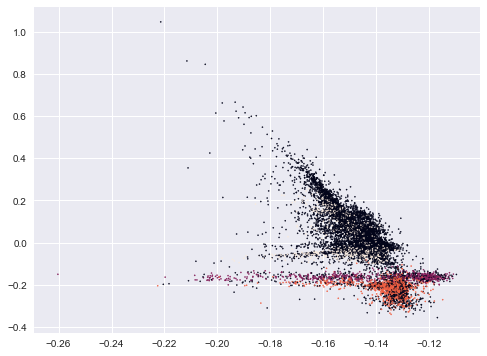

In [123]:
plt.figure(figsize=(8,6))
sample = pd.Series(range(307508)).sample(frac=0.05)
plt.scatter(glrm_vis_df.Arch1.iloc[sample], 
            glrm_vis_df.Arch2.iloc[sample], 
            s=1.5, c=cluster_labels.iloc[:,0][sample])
plt.show()

In [126]:
test_feature(pd.get_dummies(cluster_labels.iloc[:,0].astype(str)))

Train AUROC mean gain as z-score: -0.3
Test AUROC mean gain as z-score: -0.29
Train f1-score mean gain as z-score: 0.26
Test f1-score mean gain as z-score: 0.22
  (elapsed time: 1.1 minutes)


The default settings turned out a set of labels that don't boost performance at all.  As it turns out,  forcing more clusters by tweaking parameters turns out to be very tricky and computationally expensive, so we'll move on for now.

## Anomaly Detection Algorithms

### Isolation Forest

In [169]:
from sklearn.ensemble import IsolationForest
start = time()

iso = IsolationForest(n_estimators=300, contamination=0.08)
iso.fit(glrm_df)
iso_flag = 1 - iso.predict(glrm_df) # makes flag such that 1 means outlier (strange that it isn't, by default)
iso_prob = iso.decision_function(glrm_df)
print("Elapsed time:", round((time()-start)/60, 1), 'minutes')

Elapsed time: 2.6 minutes


In [170]:
test_feature(np.column_stack([iso_flag, iso_prob]))

Train AUROC mean gain as z-score: 0.99
Test AUROC mean gain as z-score: 0.22
Train f1-score mean gain as z-score: -0.12
Test f1-score mean gain as z-score: -0.35
  (elapsed time: 1.1 minutes)


No significant gains from this one, either.

### Local Outlier Factor

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

start = time()
lof = LocalOutlierFactor(contamination=positives_ratio)
pred = lof.fit_predict(glrm_df)

# convert +1/-1 output to 1/0:
pred = (1-pred)/2
lof_pred = pred

print("Score: ", round(f1_score(y, pred), 3))
false_neg = sum((y - pred) == 1)
false_pos = sum((y - pred) == -1)
print("False negatives: ", false_neg)
print('False positives: ', false_pos)
print("elapsed time:", round((time()-start)/60, 1), 'minutes')

In [ ]:
lof_pred.columns=['lof_pred']
pd.DataFrame(lof_pred).to_csv('lof_pred2.csv')

In [307]:
# reload from previous run:
lof_pred = pd.read_csv('lof_pred.csv', index_col=1).reset_index(drop=True)
lof_pred.columns=['lof_pred']

In [310]:
test_feature(lof_pred)

Train AUROC mean gain as z-score: 0.37
Test AUROC mean gain as z-score: -0.14
Train f1-score mean gain as z-score: 0.72
Test f1-score mean gain as z-score: 0.25
  (elapsed time: 2.4 minutes)


Again, we see no significant gains.

## Other predictive models: Gaussian Naive Bayes

Here we'll try running a GNB classifier on the dataset and tweaking parameters to emphasize different quadrants of the confusion matrix.  The idea is that although their accuracies are less than our lgbmc model's accuracy, if one of the GNB models classifies positives better, and one of them classifies negative model, their flags may prove useful to the overall lgbmc model – basically, a rudimentary sort of boosting.  (Note: I also tried a full boosting model, viewable in the appendix at the end of this notebook; it didn't improve results.)  Another reason to think these flags might prove useful is that a GBN classifier is using fundamentally different math than lgbmc, so it may pick up on some different aspects of the dataset.

This algorithm is fast enough to run on the full dataset.  However, the full dataset is a mix of various distributions, so neither a GNB or a Bernoulli or Poisson NB classifier would be very accurate.  For this reason, we're running the model on the GLRM dataset, whose feature distributions generally resemble a normal distribution.


In [188]:
glrm_all = pd.read_csv('glrm1.5_df.csv', index_col=0) 
# this is a glrm reduction of a version of the full dataset (not ft-importance-only)

  train AUROC: 0.712
  test AUROC: 0.71
  train f1-score: 0.243
  test f1-score: 0.245
elapsed time: 0.0 minutes


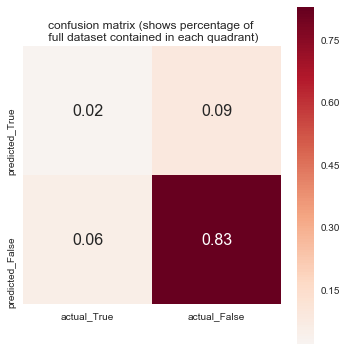

In [195]:
# targeting False flags (0.92 of the full dataset):
from sklearn.naive_bayes import GaussianNB
gnb1 = GaussianNB(priors=[0.7, 0.3])
quick_test_model(gnb1, glrm_all, y)
show_conf_mat(gnb1, glrm_all, y)

  train AUROC: 0.709
  test AUROC: 0.71
  train f1-score: 0.204
  test f1-score: 0.203
elapsed time: 0.0 minutes


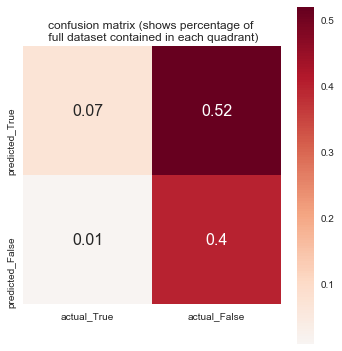

In [192]:
# targeting True flags (0.08 of the full dataset):
gnb2 = GaussianNB(priors=[0.35, 0.65])
quick_test_model(gnb2, glrm_all, y)
show_conf_mat(gnb2, glrm_all, y)

In [196]:
gnb1_pred = pd.Series(gnb1.predict(glrm_all))
gnb1_prob = pd.Series(gnb1.predict_proba(glrm_all)[:,0])
gnb2_pred = pd.Series(gnb2.predict(glrm_all))
gnb2_prob = pd.Series(gnb2.predict_proba(glrm_all)[:,0])
gnb_boost_df = pd.concat([gnb1_pred, gnb1_prob, gnb2_pred, gnb2_prob], axis=1)
gnb_boost_df.columns = ['gnb1_flag', 'gnb1_prob', 'gnb2_flag', 'gnb2_prob']

In [197]:
test_feature(gnb_boost_df)

Train AUROC mean gain as z-score: 5.79
Test AUROC mean gain as z-score: 4.24
Train f1-score mean gain as z-score: 2.07
Test f1-score mean gain as z-score: 3.64
  (elapsed time: 1.1 minutes)


This is a good sign!  Let's take a look at the individual features:

In [199]:
for col in gnb_boost_df.columns:
    print("\n", col)
    test_feature(gnb_boost_df[col])


 gnb1_flag
Train AUROC mean gain as z-score: 1.79
Test AUROC mean gain as z-score: 1.21
Train f1-score mean gain as z-score: 1.67
Test f1-score mean gain as z-score: 1.82
  (elapsed time: 1.2 minutes)

 gnb1_prob
Train AUROC mean gain as z-score: 11.76
Test AUROC mean gain as z-score: 8.69
Train f1-score mean gain as z-score: 1.9
Test f1-score mean gain as z-score: 2.88
  (elapsed time: 1.1 minutes)

 gnb2_flag
Train AUROC mean gain as z-score: 0.06
Test AUROC mean gain as z-score: 1.8
Train f1-score mean gain as z-score: -2.15
Test f1-score mean gain as z-score: -0.31
  (elapsed time: 1.1 minutes)

 gnb2_prob
Train AUROC mean gain as z-score: 3.02
Test AUROC mean gain as z-score: 2.79
Train f1-score mean gain as z-score: 3.4
Test f1-score mean gain as z-score: 1.77
  (elapsed time: 1.2 minutes)


Since all of these come back as likely to be significant, we'll append all of them to our to-add dataset.

In [202]:
for col in gnb_boost_df.columns:
    boost_additions_df[col] = gnb_boost_df[col].copy()

# Hyperparameter Sweeps

Now that we've finished adding engineered and boosted features, we should run a hyperparameter sweep.  I've included a basic low-n_estimators version here, but ultimately we may want to take our parameters from one of the public kernels that users have optimized using Bayesian optimizers with tons of computational power and massive numbers of estimators in the algorithm.

In [322]:
from sklearn.model_selection import RandomizedSearchCV

# report utility function from http://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [331]:
lgbmc = LGBMClassifier()

param_dist = {'class_weight':['balanced'],
              "n_estimators":[100, 200, 300],
              "num_leaves": [6,8,10,14,18,22,28,36,44],
              "min_data_in_leaf": [200,500,800,1200,2000,4000],
              "min_samples_split": [2,10,20],
              "reg_alpha": [0,1,2,5,10],
              "reg_lambda": [0,0.1,0.3,0.6,1],
              "boosting_type": ["gbdt", "goss"],
              "random_state": [11],
              "return train score": [True]
}

random_search = RandomizedSearchCV(lgbmc, param_distributions=param_dist, n_iter=30, cv=3, scoring='roc_auc')
start = time()
random_search.fit(full_dummy_df, y)

print("elapsed time:", round((time()-start)/60, 1), 'minutes')
report(random_search.cv_results_, n_top=5)

elapsed time: 113.6 minutes
Model with rank: 1
Mean validation score: 0.784 (std: 0.002)
Parameters: {'return train score': True, 'reg_lambda': 1, 'reg_alpha': 2, 'random_state': 11, 'num_leaves': 14, 'n_estimators': 300, 'min_samples_split': 2, 'min_data_in_leaf': 1200, 'class_weight': 'balanced', 'boosting_type': 'goss'}

Model with rank: 2
Mean validation score: 0.784 (std: 0.002)
Parameters: {'return train score': True, 'reg_lambda': 0, 'reg_alpha': 5, 'random_state': 11, 'num_leaves': 18, 'n_estimators': 300, 'min_samples_split': 20, 'min_data_in_leaf': 4000, 'class_weight': 'balanced', 'boosting_type': 'gbdt'}

Model with rank: 3
Mean validation score: 0.783 (std: 0.002)
Parameters: {'return train score': True, 'reg_lambda': 0.1, 'reg_alpha': 1, 'random_state': 11, 'num_leaves': 14, 'n_estimators': 300, 'min_samples_split': 2, 'min_data_in_leaf': 800, 'class_weight': 'balanced', 'boosting_type': 'goss'}

Model with rank: 4
Mean validation score: 0.783 (std: 0.001)
Parameters: {'r

  train AUROC: 0.842
  test AUROC: 0.795
  train f1-score: 0.338
  test f1-score: 0.304
elapsed time: 2.2 minutes


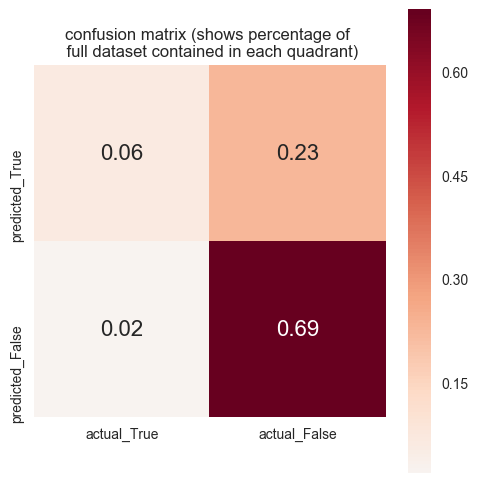

In [383]:
best_params = {'class_weight':'balanced',
              'reg_lambda': 1, 
              'reg_alpha': 2, 
              'random_state': 11, 
              'num_leaves': 14, 
              'n_estimators': 300, 
              'min_samples_split': 2, 
              'min_data_in_leaf': 1200, 
              'boosting_type': 'goss'}

lgbmc = LGBMClassifier(**best_params)
quick_test_model(lgbmc, full_dummy_df, y)
show_conf_mat(lgbmc, full_dummy_df, y)

# Final CV score

To get a better sense of my final result here, I'll generate a mean score from several tests where the model trains on 90% of the training data.  This will give us a more accurate estimate of the actual score we'll achieve in the contest training on 100% of the training data.  (We won't do a full 10-fold CV test because it would take roughly five hours on this machine; instead, to make sure the results are consistent, we'll calculate the standard deviation.)

### With parameters from bayesian optimization in public kernels:

The parameters in the first test below are primarily taken from the results of the Bayesian Optimization process in the public kernel at https://www.kaggle.com/ogrellier/lighgbm-with-selected-features/code and https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code.

In [104]:
train_f1s = []
test_f1s = []
train_aurocs = []
test_aurocs = []

params = {
    'class_weight':'balanced',
    'n_estimators':7000,
    'learning_rate':0.02,
    'num_leaves':15,
    'colsample_bytree':0.95,
    'subsample':0.85,
    'max_depth':8,
    'reg_alpha':0.04,
    'reg_lambda':0.073,
    'min_split_gain':0.022,
    'min_child_weight':60,
    'metric':'auc'
}
    
lgbmc_cv3 = LGBMClassifier(**params)

start = time()

for i in range(3):
    X_train, X_test, y_train, y_test = train_test_split(pared_df, y, test_size=0.1)
    lgbmc_cv3.fit(X_train, y_train)
    
    y_train_proba = lgbmc_cv3.predict_proba(X_train)[:,1]
    y_test_proba = lgbmc_cv3.predict_proba(X_test)[:,1]
    y_pred_train = lgbmc_cv3.predict(X_train)
    y_pred_test = lgbmc_cv3.predict(X_test)

    train_auroc = round(roc_auc_score(y_train, y_train_proba), 3)
    test_auroc = round(roc_auc_score(y_test, y_test_proba), 3) 
    train_f1 = round(f1_score(y_train, y_pred_train), 3)
    test_f1 = round(f1_score(y_test, y_pred_test), 3)   
 
    train_aurocs.append(train_auroc)
    test_aurocs.append(test_auroc)
    train_f1s.append(train_f1)
    test_f1s.append(test_f1)


train_auroc_error = np.std(train_aurocs)*1.96
test_auroc_error = np.std(test_aurocs)*1.96
train_f1_error = np.std(train_f1)*1.96
test_f1_error = np.std(test_f1)*1.96

print("Final 90/10 cv results at 95% confidence:")

print("\n  train AUROC:", round(np.mean(train_aurocs), 3), "±", round(train_auroc_error, 3))
print("  test AUROC:", round(np.mean(test_aurocs), 3), "±", round(test_auroc_error, 3))
print("     ({} --> {})".format(
    round(np.mean(test_aurocs) - test_auroc_error, 3),
    round(np.mean(test_aurocs) + test_auroc_error, 3)))

print("\n  train f1-score:", round(np.mean(train_f1s), 3), "±", round(train_f1_error, 3))
print("  test f1-score:", round(np.mean(test_f1s), 3), "±", round(test_f1_error, 3))
print("     ({} --> {})".format(
    round(np.mean(test_f1s) - test_f1_error, 3),
    round(np.mean(test_f1s) + test_f1_error, 3)))

print("\nelapsed time:", round((time()-start)/60, 1), 'minutes')

Final 90/10 cv results at 95% confidence:

  train AUROC: 0.945 ± 0.001
  test AUROC: 0.789 ± 0.009
     (0.78 --> 0.798)

  train f1-score: 0.494 ± 0.0
  test f1-score: 0.321 ± 0.0
     (0.321 --> 0.321)

elapsed time: 133.0 minutes


Adding the boosting columns and decreasing the learning rate a touch (and decreasing n_estimators a touch for the sake of time):

In [212]:
train_f1s = []
test_f1s = []
train_aurocs = []
test_aurocs = []

params = {
    'class_weight':'balanced',
    'n_estimators':5000,
    'learning_rate':0.015,
    'num_leaves':15,
    'colsample_bytree':0.95,
    'subsample':0.85,
    'max_depth':8,
    'reg_alpha':0.04,
    'reg_lambda':0.073,
    'min_split_gain':0.022,
    'min_child_weight':60,
    'metric':'auc'
}
    
lgbmc_cv3 = LGBMClassifier(**params)

start = time()

for i in range(2):
    X_train, X_test, y_train, y_test = train_test_split(
        pd.concat([pared_df, boost_additions_df], axis=1), 
        y, 
        test_size=0.1)    
    
    lgbmc_cv3.fit(X_train, y_train)
    
    y_train_proba = lgbmc_cv3.predict_proba(X_train)[:,1]
    y_test_proba = lgbmc_cv3.predict_proba(X_test)[:,1]
    y_pred_train = lgbmc_cv3.predict(X_train)
    y_pred_test = lgbmc_cv3.predict(X_test)

    train_auroc = round(roc_auc_score(y_train, y_train_proba), 3)
    test_auroc = round(roc_auc_score(y_test, y_test_proba), 3) 
    train_f1 = round(f1_score(y_train, y_pred_train), 3)
    test_f1 = round(f1_score(y_test, y_pred_test), 3)   
 
    train_aurocs.append(train_auroc)
    test_aurocs.append(test_auroc)
    train_f1s.append(train_f1)
    test_f1s.append(test_f1)


train_auroc_error = np.std(train_aurocs)*1.96
test_auroc_error = np.std(test_aurocs)*1.96
train_f1_error = np.std(train_f1)*1.96
test_f1_error = np.std(test_f1)*1.96

print("Final 90/10 cv results at 95% confidence:")

print("\n  train AUROC:", round(np.mean(train_aurocs), 3), "±", round(train_auroc_error, 3))
print("  test AUROC:", round(np.mean(test_aurocs), 3), "±", round(test_auroc_error, 3))
print("     ({} --> {})".format(
    round(np.mean(test_aurocs) - test_auroc_error, 3),
    round(np.mean(test_aurocs) + test_auroc_error, 3)))

print("\n  train f1-score:", round(np.mean(train_f1s), 3), "±", round(train_f1_error, 3))
print("  test f1-score:", round(np.mean(test_f1s), 3), "±", round(test_f1_error, 3))
print("     ({} --> {})".format(
    round(np.mean(test_f1s) - test_f1_error, 3),
    round(np.mean(test_f1s) + test_f1_error, 3)))

print("\nelapsed time:", round((time()-start)/60, 1), 'minutes')

Final 90/10 cv results at 95% confidence:

  train AUROC: 0.899 ± 0.0
  test AUROC: 0.796 ± 0.001
     (0.795 --> 0.796)

  train f1-score: 0.404 ± 0.0
  test f1-score: 0.313 ± 0.0
     (0.313 --> 0.313)

elapsed time: 74.6 minutes


In [400]:
pd.DataFrame(y_pred_test).to_csv('y_pred_cv3.csv')
pd.DataFrame(y_test).to_csv('y_test3.csv')
pd.DataFrame(X_test).to_csv('x_test3.csv')

### With parameters from my hyperparameter sweep:

In [105]:
best_params = {'class_weight':'balanced',
              'reg_lambda': 1, 
              'reg_alpha': 2, 
              'random_state': 11, 
              'num_leaves': 14, 
              'n_estimators': 300, 
              'min_samples_split': 2, 
              'min_data_in_leaf': 1200, 
              'boosting_type': 'goss'}

train_f1s = []
test_f1s = []
train_aurocs = []
test_aurocs = []

lgbmc_cv4 = LGBMClassifier(**best_params)

start = time()

for i in range(4):
    X_train, X_test, y_train, y_test = train_test_split(pared_df, y, test_size=0.1)
    lgbmc_cv4.fit(X_train, y_train)
    
    y_train_proba = lgbmc_cv4.predict_proba(X_train)[:,1]
    y_test_proba = lgbmc_cv4.predict_proba(X_test)[:,1]
    y_pred_train = lgbmc_cv4.predict(X_train)
    y_pred_test = lgbmc_cv4.predict(X_test)

    train_auroc = round(roc_auc_score(y_train, y_train_proba), 3)
    test_auroc = round(roc_auc_score(y_test, y_test_proba), 3) 
    train_f1 = round(f1_score(y_train, y_pred_train), 3)
    test_f1 = round(f1_score(y_test, y_pred_test), 3)   
 
    train_aurocs.append(train_auroc)
    test_aurocs.append(test_auroc)
    train_f1s.append(train_f1)
    test_f1s.append(test_f1)


train_auroc_error = np.std(train_aurocs)*1.96
test_auroc_error = np.std(test_aurocs)*1.96
train_f1_error = np.std(train_f1)*1.96
test_f1_error = np.std(test_f1)*1.96

print("Final 90/10 cv results at 95% confidence:")

print("\n  train AUROC:", round(np.mean(train_aurocs), 3), "±", round(train_auroc_error, 3))
print("  test AUROC:", round(np.mean(test_aurocs), 3), "±", round(test_auroc_error, 3))
print("     ({} --> {})".format(
    round(np.mean(test_aurocs) - test_auroc_error, 3),
    round(np.mean(test_aurocs) + test_auroc_error, 3)))

print("\n  train f1-score:", round(np.mean(train_f1s), 3), "±", round(train_f1_error, 3))
print("  test f1-score:", round(np.mean(test_f1s), 3), "±", round(test_f1_error, 3))
print("     ({} --> {})".format(
    round(np.mean(test_f1s) - test_f1_error, 3),
    round(np.mean(test_f1s) + test_f1_error, 3)))

print("\nelapsed time:", round((time()-start)/60, 1), 'minutes')

Final 90/10 cv results at 95% confidence:

  train AUROC: 0.831 ± 0.001
  test AUROC: 0.79 ± 0.007
     (0.784 --> 0.797)

  train f1-score: 0.327 ± 0.0
  test f1-score: 0.298 ± 0.0
     (0.298 --> 0.298)

elapsed time: 20.6 minutes


### With parameters from my hyperparameter sweep + more trees:

In [107]:
best_params = {'class_weight':'balanced',
              'reg_lambda': 1, 
              'reg_alpha': 2, 
              'random_state': 12, 
              'num_leaves': 14, 
              'n_estimators': 2000, 
              'min_samples_split': 2, 
              'min_data_in_leaf': 1200, 
              'boosting_type': 'goss'}

train_f1s = []
test_f1s = []
train_aurocs = []
test_aurocs = []

lgbmc_cv4 = LGBMClassifier(**best_params)

start = time()

for i in range(4):
    X_train, X_test, y_train, y_test = train_test_split(pared_df, y, test_size=0.1)
    lgbmc_cv4.fit(X_train, y_train)
    
    y_train_proba = lgbmc_cv4.predict_proba(X_train)[:,1]
    y_test_proba = lgbmc_cv4.predict_proba(X_test)[:,1]
    y_pred_train = lgbmc_cv4.predict(X_train)
    y_pred_test = lgbmc_cv4.predict(X_test)

    train_auroc = round(roc_auc_score(y_train, y_train_proba), 3)
    test_auroc = round(roc_auc_score(y_test, y_test_proba), 3) 
    train_f1 = round(f1_score(y_train, y_pred_train), 3)
    test_f1 = round(f1_score(y_test, y_pred_test), 3)   
 
    train_aurocs.append(train_auroc)
    test_aurocs.append(test_auroc)
    train_f1s.append(train_f1)
    test_f1s.append(test_f1)


train_auroc_error = np.std(train_aurocs)*1.96
test_auroc_error = np.std(test_aurocs)*1.96
train_f1_error = np.std(train_f1)*1.96
test_f1_error = np.std(test_f1)*1.96

print("Final 90/10 cv results at 95% confidence:")

print("\n  train AUROC:", round(np.mean(train_aurocs), 3), "±", round(train_auroc_error, 3))
print("  test AUROC:", round(np.mean(test_aurocs), 3), "±", round(test_auroc_error, 3))
print("     ({} --> {})".format(
    round(np.mean(test_aurocs) - test_auroc_error, 3),
    round(np.mean(test_aurocs) + test_auroc_error, 3)))

print("\n  train f1-score:", round(np.mean(train_f1s), 3), "±", round(train_f1_error, 3))
print("  test f1-score:", round(np.mean(test_f1s), 3), "±", round(test_f1_error, 3))
print("     ({} --> {})".format(
    round(np.mean(test_f1s) - test_f1_error, 3),
    round(np.mean(test_f1s) + test_f1_error, 3)))

print("\nelapsed time:", round((time()-start)/60, 1), 'minutes')

Final 90/10 cv results at 95% confidence:

  train AUROC: 0.939 ± 0.0
  test AUROC: 0.784 ± 0.004
     (0.78 --> 0.788)

  train f1-score: 0.486 ± 0.0
  test f1-score: 0.326 ± 0.0
     (0.326 --> 0.326)

elapsed time: 48.7 minutes


Both my hyperparameter-sweep parameters and the Bayesian-optimized parameters yield a score of right around 0.79 ± .008.  Oddly, the hyperparameter-sweep version decreases in accuracy with a large number of estimators -- but the f1-score *increases* significantly (it's vaguely possible, with only a few test runs here, that some part of this was a fluke).

# Conclusions

### Process
My process in this project was very involved, which was good for my personal learning, but could use some streamlining for efficiency.  In particular, knowing what I now know about LightGBM, I think it would be best to start off with a more brute-force approach and fine0tune from there.  However, there are upsides to my more boutique data-ceaning approach as well.  My knowledge of the data allowed me to think of some useful engineered features, and the performance of my model was high in both accuracy and computational efficiency thanks to a reduced featureset.  

GLRM did not prove as useful as I'd hoped - partly due to some shortcomings in the python implementation (such as lacking an imputation function), and partly due to the nature of the dataset.  In the end, I wasn't actually able to use it to boost my accuracy at all.  However, it did give me a usefully compressed and null-less version of the dataset for testing engineered features and other practical purposes.

### Outcomes
My final score with the best parameters in the 90/10 CV test above is AUROC=0.796 ± 0.001 (0.795 --> 0.797).  Given that the extra data from the earlier 67/33 split did give a significant boost, the final prediction accuracy of my pipeline when trained on 100% of the data is likely around 0.797 or 0.798.  This falls a little short of my initial goal of clearing 0.8, but it's very close.  It's about as high a score as any of the public kernels achieve (the absolute top is 0.796, but some users have reported that this is overfitting).  But it's a little below the leaderboard scores that land in the 0.800-->0.807 range.  These users may be doing more advanced feature engineering, or they may be using neural nets.

Overall, these results aren't quite as high as I'd hoped, but my final results are at least high enough to show that I'm operating on par with knowledgeable machine learning practitioners out there, which is encouraging.  And more importantly, I learned a lot (and wrote a number of useful snippets and support functions for my arsenal).

### Further investigation
While I've tried a lot of different methods here, many more remain to be tried.  The investigations here are limited by time, computational power, and existing libraries.  Techniques that seem likely to produce useful results include:
- <b>use advanced imputation on the dataset.</b> This could help with model accuracy; at the very least, it would allow the use of algorithms that can't handle nulls.  But various all my attempts at imputing faced hangups: missForest tree-based imputing only exists in R; fancyImpute's KNN- and SVD-based imputing modules are too slow; and my first choice, the h2o implementation of GLRM, has a bug such that it can't actually impute even though imputation is one of the great assets of GLRMs in general. 
- <b>using PLS or UMAP embedding for feature reduction instead of GLRM.</b> sklearn's algorithms don't support null handling, so I'd have to either impute first or seek farther afield for other PLS algorithms.  I only recently discovered UMAP embedding and would need to learn more about it before using.
- <b>try training GLRM on positive and negative examples separately.</b> This may provide further insights into the differences betwen the two groups, and allow for a clustering-based distinction model.
- <b>using a better Naive Bayes model as a booster.</b> It would be ideal to specify the distribution assumption (Gaussian, Poisson, Bernoulli, etc) for each feature; sklearn doesnt support this - you have to assemble your own composite model, which would be feasible but take a bit of legwork.  Sklearn's soon-to-be-released ComplementNB for imbalanced datasets may also perform better in some aspects.
- <b>try examining and fitting the errors.</b> It may be useful to try training a separate model on the errors (separately for false positives and false negatives) and seeing if it's possible to predict them.  This would enable a more accurate ensemble.
- <b>try a neural net.</b> I'm still in the early stages of digging into NNs and Deep Learning, so I'm not quite ready to do this well.  But it may be able to achieve a significant bump up in accuracy (albeit at significant computational cost).

# Works Cited

#### This project drew on the following resources:
- Udell et al., 2016. <a href='https://web.stanford.edu/~boyd/papers/pdf/glrm.pdf'>Generalized Low Rank Models</a>
- <a href='https://www.kaggle.com/ogrellier/lighgbm-with-selected-features/code'>public kernel</a> by Kaggle user 'olivier'
- <a href='https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features/code'>public kernel </a> by Kaggle user 'Aguiar'
- <a href='https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code'>public kernel</a> by Kaggle user 'Tilii'

# Appendix 
#### some lengthy & unexciting snippets omitted from the above

### 1. Visualization

### GLRM for visualization

In [296]:
glrmodel_vis = H2OGeneralizedLowRankEstimator(
                                       k=2,
                                       seed=11,
                                       transform="STANDARDIZE",
                                       regularization_x="None", 
                                       regularization_y="None",
                                       init='SVD',
                                       max_iterations=30, 
                                       multi_loss='categorical',
                                       #loss_by_col=[loss_by_col[c] for c in khous_run.columns], 
                                       impute_original=True)

In [297]:
start = time()
glrmodel_vis.train(training_frame=full_h2)
print('elapsed time:', round((time()-start)/60, 1), "minutes")

glrm Model Build progress: |██████████████████████████████████████████████| 100%
elapsed time: 7.0 minutes


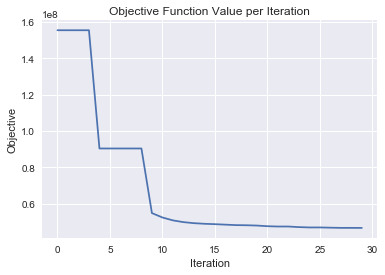

In [298]:
model_score = glrmodel_vis.score_history()
plt.xlabel("Iteration")
plt.ylabel("Objective")
plt.title("Objective Function Value per Iteration")
plt.plot(model_score["iterations"], model_score["objective"])
plt.show()

In [299]:
model = glrmodel_vis._model_json
model_out = model['output']
# num_archs = glrmodel_5.params['k']['actual']
archs_df = model_out["archetypes"].as_data_frame()
archs = np.array(archs_df)
X = h2o.get_frame(model_out['representation_name'])
glrm_vis_df = X.as_data_frame()

print('Original:', full_dataset_df.shape)
print('Projected:', glrm_vis_df.shape)

Original: (307508, 182)
Projected: (307508, 2)


In [376]:
lgbmc_glrm = LGBMClassifier(class_weight='balanced')
quick_test_model(lgbmc_glrm, glrm_vis_df, y)

  train AUROC: 0.614
  test AUROC: 0.533
  train f1-score: 0.179
  test f1-score: 0.151
elapsed time: 0.1 minutes


In [ ]:
with pd.option_context('display.max_columns', None):
    display(full_dataset_df)

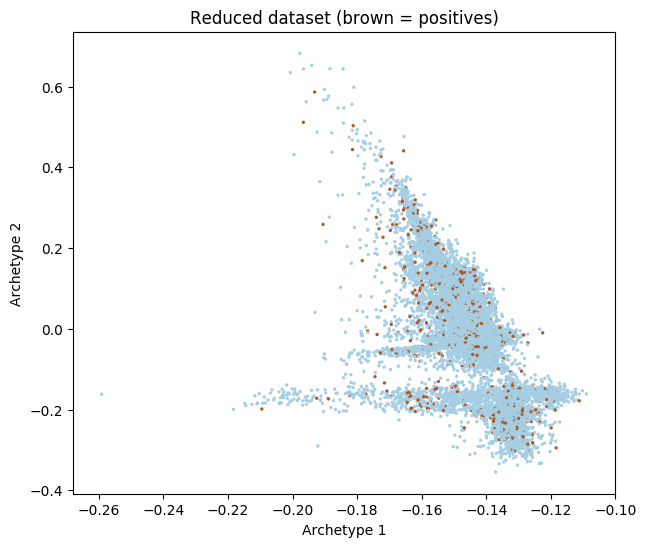

In [228]:
sns.reset_orig()
plt.figure(figsize=(7,6))
# sample = pd.Series(range(307508)).sample(frac=0.05)
plt.scatter(glrm_vis_df.Arch1.iloc[sample], 
            glrm_vis_df.Arch2.iloc[sample], 
            s=2, 
            c=pd.Series(y).iloc[sample],
            cmap='Paired')
plt.xlabel("Archetype 1")
plt.ylabel("Archetype 2")
plt.title("Reduced dataset (brown = positives)")
plt.show()
sns.set()

### 2. GLRM column types

In [243]:
for col in full_dataset_df.columns:
    if col not in glrm_column_types:
        print("Not in column_types:", col)

for col in glrm_column_types.keys():
    if col not in full_dataset_df.columns:
        print("dict col not in dframe:", col)        

Not in column_types: sk_id_curr
Not in column_types: target


In [500]:
# commented out columns are features since removed for uselessness
glrm_column_types = {
    #'sk_id_curr':                                                    'int',
    'payment_rate':                                                  'real',
    'relative_annuity':                                              'real',
    'pct_days_employed':                                             'real',
    'housing_per_income':                                            'real',
    'ext_combined':                                                  'real',
    #'occupation_type_seq':                                           'int',
    'name_contract_type_x':                                           'enum',
    'flag_own_car':                                                   'enum',
    'flag_own_realty':                                                'enum',
    #'cnt_children':                                                  'int',
    'amt_income_total':                                              'real',
    'amt_credit_x':                                                  'real',
    'amt_annuity_x':                                                 'real',
    'name_type_suite_x':                                              'enum',
    'name_income_type':                                               'enum',
    'name_education_type':                                            'enum',
    'name_family_status':                                             'enum',
    'name_housing_type':                                              'enum',
    'region_population_relative':                                    'real',
    'days_birth':                                                      'int',
    'days_employed':                                                   'int',
    'days_registration':                                             'real',
    'days_id_publish':                                                 'int',
    'own_car_age':                                                   'real',
    'flag_work_phone':                                                 'enum',
    'flag_phone':                                                      'enum',
    #'flag_email':                                                      'enum',
    'occupation_type':                                                'real',
    'region_rating_client':                                            'int',
    'weekday_appr_process_start_x':                                   'enum',
    'hour_appr_process_start_x':                                       'int',
    #'reg_region_not_live_region':                                      'enum',
    #'reg_region_not_work_region':                                      'enum',
    'reg_city_not_live_city':                                          'enum',
    'reg_city_not_work_city':                                          'enum',
    'organization_type':                                              'float', # encoded
    'organization_type_seq':                                           'enum',
    'ext_source_1':                                                'real',
    'ext_source_2':                                                  'real',
    'ext_source_3':                                                  'real',
    'fondkapremont_mode':                                             'enum',
    'wallsmaterial_mode':                                             'enum',
    'obs_30_cnt_social_circle':                                      'real',
    'def_30_cnt_social_circle':                                      'real',
    'obs_60_cnt_social_circle':                                      'real',
    'def_60_cnt_social_circle':                                      'real',
    'days_last_phone_change':                                        'real',
    'flag_document_3':                                                 'enum',
    'flag_document_13':                                                'enum',
    #'flag_document_14':                                                'enum',
    #'flag_document_15':                                                'enum',
    #'flag_document_17':                                                'enum',
    'flag_document_18':                                                'enum',
    #'flag_document_20':                                                'enum',
    #'flag_document_21':                                                'enum',
    #'amt_req_credit_bureau_hour':                                    'real',
    #'amt_req_credit_bureau_day':                                     'real',
    #'amt_req_credit_bureau_week':                                    'real',
    'amt_req_credit_bureau_mon':                                     'real',
    'amt_req_credit_bureau_qrt':                                     'real',
    'amt_req_credit_bureau_year':                                    'real',
    'gender_female':                                                 'enum',
    'housing_age':                                                   'real',
    'other_null_count':                                                'int',
    'housing_quality':                                               'real',
    'amt_annuity_y':                                                 'real',
    'amt_application_x':                                             'real',
    'amt_credit_y':                                                  'real',
    'amt_down_payment_x':                                            'real',
    'amt_goods_price_x':                                             'real',
    'av_dpd_major_x':                                                'real',
    'av_dpd_minor_x':                                                'real',
    'channel_type_x':                                                 'enum',
    'cnt_payment_x':                                                 'real',
    'code_reject_reason_x':                                           'enum',
    'days_decision_x':                                               'real',
    'days_first_drawing_x':                                          'real',
    'days_first_due_x':                                              'real',
    'days_instalment_max_x':                                         'real',
    'days_instalment_min_x':                                         'real',
    'days_last_due_x':                                               'real',
    'days_last_due_1st_version_x':                                   'real',
    'days_late_max_x':                                               'real',
    'days_late_mean_x':                                              'real',
    'days_termination_x':                                            'real',
    'flag_last_appl_per_contract_x':                                  'enum',
    'hour_appr_process_start_y':                                     'real',
    'name_client_type_x':                                             'enum',
    'name_contract_status':                                           'enum',
    'name_contract_type_y':                                           'enum',
    'name_goods_category_x':                                          'enum',
    'name_payment_type':                                              'enum',
    'name_portfolio_x':                                               'enum',
    'name_product_type_x':                                            'enum',
    'name_seller_industry_x':                                         'enum',
    'name_type_suite_y':                                              'enum',
    'name_yield_group_x':                                             'enum',
    'nflag_insured_on_approval_x':                                   'enum',
    #'nflag_last_appl_in_day_x':                                      'enum',
    'num_instalment_number_count_x':                                 'real',
    'pcb_name_contract_status_Active_x':                             'real',
    #'pcb_name_contract_status_Approved_x':                            'real',
    'pcb_name_contract_status_Completed_x':                           'real',
    #'pcb_name_contract_status_Returned to the store':                 'real',
    #'pcb_name_contract_status_Signed_x':                             'real',
    'pct_unpaid_max_x':                                              'real',
    'pct_unpaid_mean_x':                                             'real',
    'product_combination_x':                                          'enum',
    'sellerplace_area_x':                                            'real',
    'sk_id_prev':                                                    'real',
    'weekday_appr_process_start_y':                                   'enum',
    'name_contract_type_Cash_loans':                                 'real',
    'name_contract_type_Consumer_loans':                             'real',
    'name_contract_type_Revolving_loans':                             'real',
    #'name_contract_type_XNA':                                        'real',
    'name_contract_status_1_Approved':                                 'real',
    'name_contract_status_1_Canceled':                                 'real',
    'name_contract_status_1_Refused':                                  'real',
    'name_contract_status_Unused_offer':                             'real',
    'name_payment_type_Cash_through_the_bank':                        'real',
    #'name_payment_type_Cashless_from_the_account_of_the_employer':    'real',
    #'name_payment_type_Non-cash_from_your_account':                   'real',
    'name_payment_type_1_XNA':                                         'real',
    'prev_app_count_x':                                              'real',
    'amt_annuity_x.1':                                               'real',
    'amt_application_y':                                             'real',
    'amt_credit':                                                    'real',
    'amt_down_payment_y':                                            'real',
    'amt_goods_price_y':                                             'real',
    'hour_appr_process_start':                                       'real',
    #'flag_last_appl_per_contract_y':                                 'real',
    #'nflag_last_appl_in_day_y':                                      'real',
    'days_decision_y':                                               'real',
    'sellerplace_area_y':                                            'real',
    'cnt_payment_y':                                                 'real',
    'days_first_drawing_y':                                          'real',
    'days_first_due_y':                                              'real',
    'days_last_due_1st_version_y':                                   'real',
    'days_last_due_y':                                               'real',
    'days_termination_y':                                            'real',
    'nflag_insured_on_approval_y':                                   'real',
    'av_dpd_minor_y':                                                'real',
    'av_dpd_major_y':                                                'real',
    'pcb_name_contract_status_Active_y':                             'real',
    #'pcb_name_contract_status_Approved_y':                            'real',
    'pcb_name_contract_status_Completed_y':                           'real',
    #'pcb_name_contract_status_Demand_y':                             'real',
    #'pcb_name_contract_status_Returned_to_the_store':                 'real',
    'pcb_name_contract_status_Signed_y':                             'real',
    'num_instalment_number_count_y':                                 'real',
    'days_instalment_min_y':                                         'real',
    'days_instalment_max_y':                                         'real',
    'pct_unpaid_mean_y':                                             'real',
    'pct_unpaid_max_y':                                              'real',
    'days_late_mean_y':                                              'real',
    'days_late_max_y':                                               'real',
    'weekday_appr_process_start':                                     'enum',
    'code_reject_reason_y':                                           'enum',
    'name_type_suite':                                                'enum',
    'name_client_type_y':                                             'enum',
    'name_goods_category_y':                                          'enum',
    'name_portfolio_y':                                               'enum',
    'name_product_type_y':                                            'enum',
    'channel_type_y':                                                 'enum',
    'name_seller_industry_y':                                         'enum',
    'name_yield_group_y':                                             'enum',
    'product_combination_y':                                          'enum',
    'amt_annuity_y.1':                                               'real',
    'amt_credit_max_overdue_x':                                      'real',
    'amt_credit_sum_x':                                              'real',
    'amt_credit_sum_debt_x':                                         'real',
    'amt_credit_sum_limit_x':                                        'real',
    'amt_credit_sum_overdue_x':                                      'real',
    #'cnt_credit_prolong_x':                                          'real',
    'credit_active':                                                  'enum',
    'credit_currency_x':                                              'enum',
    #'credit_day_overdue_x':                                          'real',
    'credit_type_x':                                                  'enum',
    'days_credit_x':                                                 'real',
    'days_credit_enddate_x':                                         'real',
    'days_credit_update_x':                                          'real',
    'days_enddate_fact_x':                                           'real',
    'sk_id_bureau':                                                  'real',
    'status_0_x':                                                    'real',
    #'status_1_x':                                                    'real',
    #'status_2_x':                                                    'real',
    #'status_3_x':                                                    'real',
    #'status_4_x':                                                    'real',
    #'status_5_x':                                                    'real',
    'status_C_x':                                                    'real',
    'status_X_x':                                                    'real',
    'total_months_x':                                                'real',
    'credit_active_1_Active':                                          'real',
    'credit_active_1_Closed':                                          'real',
    #'credit_active_1_Sold':                                            'real',
    'prev_app_count_y':                                              'real',
    'days_credit_y':                                                 'real',
    #'credit_day_overdue_y':                                          'real',
    'days_credit_enddate_y':                                         'real',
    'days_enddate_fact_y':                                           'real',
    'amt_credit_max_overdue_y':                                      'real',
    #'cnt_credit_prolong_y':                                          'real',
    'amt_credit_sum_y':                                              'real',
    'amt_credit_sum_debt_y':                                         'real',
    'amt_credit_sum_limit_y':                                        'real',
    'amt_credit_sum_overdue_y':                                      'real',
    'days_credit_update_y':                                          'real',
    'amt_annuity':                                                   'real',
    'status_0_y':                                                    'real',
    'status_1_y':                                                    'real',
    #'status_2_y':                                                    'real',
    #'status_3_y':                                                    'real',
    #'status_4_y':                                                    'real',
    #'status_5_y':                                                    'real',
    'status_C_y':                                                    'real',
    'status_X_y':                                                    'real',
    'total_months_y':                                                'real',
    'credit_currency_y':                                              'enum',
    'credit_type_y':                                                  'enum',
}

### 3. Unsuccesful GNB boosting / ensembling

First, with the feature-reduced glrm features:

In [204]:
# create datasets:
full_glrm_df = pd.concat([pared_df, glrm_df], axis=1)

X_train, X_test, y_train, y_test = train_test_split(full_glrm_df, y, test_size=1/3)
glrm_train = X_train[glrm_df.columns]
glrm_test = X_test[glrm_df.columns]
X_train = X_train.drop(glrm_df.columns, axis=1)
X_test = X_test.drop(glrm_df.columns, axis=1)

del full_glrm_df

In [205]:
best_params = {'class_weight':'balanced',
              'reg_lambda': 1, 
              'reg_alpha': 2, 
              'random_state': 11, 
              'num_leaves': 14, 
              'n_estimators': 300, 
              'min_samples_split': 2, 
              'min_data_in_leaf': 1200, 
              'boosting_type': 'goss'}

# lgbmc classifier:
lgbmc1 = LGBMClassifier(**best_params)
lgbmc1.fit(X_train, y_train)
# GNB target Negatives:
gnb1 = GaussianNB(priors=[0.7, 0.3])
gnb1.fit(glrm_train, y_train)
# GNB target Positivies:
gnb2 = GaussianNB(priors=[0.35, 0.65])
gnb2.fit(glrm_train, y_train)
# GNB target Negatives harder:
gnb3 = GaussianNB(priors=[0.85, 0.15])
gnb3.fit(glrm_train, y_train)
# GNB target Positives harder:
gnb4 = GaussianNB(priors=[0.2, 0.8])
gnb4.fit(glrm_train, y_train)

# create separate positive and negative result columns:
lgbmc_pred = lgbmc1.predict(X_test)
lgbmc_prob = lgbmc1.predict_proba(X_test)[:,0]
gnb1_pred = pd.Series(gnb1.predict(glrm_test))
gnb1_prob = pd.Series(gnb1.predict_proba(glrm_test)[:,0])
gnb2_pred = pd.Series(gnb2.predict(glrm_test))
gnb2_prob = pd.Series(gnb2.predict_proba(glrm_test)[:,0])
gnb3_pred = pd.Series(gnb3.predict(glrm_test))
gnb3_prob = pd.Series(gnb3.predict_proba(glrm_test)[:,0])
gnb4_pred = pd.Series(gnb4.predict(glrm_test))
gnb4_prob = pd.Series(gnb4.predict_proba(glrm_test)[:,0])

# compile them into a dataframe:
gnb_boost_df = pd.DataFrame()
gnb_boost_df['gnb1_if_true'] = gnb1_pred * gnb1_prob
gnb_boost_df['gnb1_if_false'] = -(gnb1_pred-1) * gnb1_prob
gnb_boost_df['gnb2_if_true'] = gnb2_pred * gnb2_prob
gnb_boost_df['gnb2_if_false'] = -(gnb2_pred-1) * gnb2_prob
gnb_boost_df['gnb3_if_true'] = gnb3_pred * gnb3_prob
gnb_boost_df['gnb3_if_false'] = -(gnb3_pred-1) * gnb3_prob
gnb_boost_df['gnb4_if_true'] = gnb4_pred * gnb4_prob
gnb_boost_df['gnb4_if_false'] = -(gnb4_pred-1) * gnb4_prob
gnb_boost_df['base_LGBM_if_true'] = lgbmc_pred * lgbmc_prob
gnb_boost_df['base_LGBM_if_false'] = -(lgbmc_pred-1) * lgbmc_prob

# run a logistic regression that uses all of these 
from sklearn.linear_model import SGDClassifier
sgdc = SGDClassifier(loss='log', penalty='l1', class_weight='balanced')
quick_test_model(sgdc, gnb_boost_df, y_test)

# view coefficients:
print("coefficients:\n")
for tup in zip(gnb_boost_df.columns, sgdc.coef_[0]):
    print(tup)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


  train AUROC: 0.784
  test AUROC: 0.782
  train f1-score: 0.274
  test f1-score: 0.275
elapsed time: 0.0 minutes
coefficients:

('gnb1_if_true', 0.2581797634626368)
('gnb1_if_false', 0.0)
('gnb2_if_true', 0.0)
('gnb2_if_false', 0.0)
('gnb3_if_true', 0.0)
('gnb3_if_false', 0.0)
('gnb4_if_true', -0.05932035170320646)
('gnb4_if_false', -0.1719369714062552)
('base_LGBM_if_true', -4.710708373236913)
('base_LGBM_if_false', -4.489374718639963)


We can also try this with an SVM:

In [ ]:
from sklearn.svm import SVC
clf = SVC(class_weight='balanced', probability=True)
quick_test_model(clf, gnb_boost_df[:60000], y_test[:60000])

# takes 10 minutes
# test AUROC: 0.757
# test F-1: 0.299

In [206]:
del X_train, X_test, y_train, y_test, glrm_train, glrm_test

then, with the full-dataset glrm features:

In [207]:
# create datasets:
full_glrm_df = pd.concat([pared_df, glrm_all], axis=1)

X_train, X_test, y_train, y_test = train_test_split(full_glrm_df, y, test_size=1/3)
glrm_train = X_train[glrm_df.columns]
glrm_test = X_test[glrm_df.columns]
X_train = X_train.drop(glrm_df.columns, axis=1)
X_test = X_test.drop(glrm_df.columns, axis=1)

del full_glrm_df

In [208]:
best_params = {'class_weight':'balanced',
              'reg_lambda': 1, 
              'reg_alpha': 2, 
              'random_state': 11, 
              'num_leaves': 14, 
              'n_estimators': 300, 
              'min_samples_split': 2, 
              'min_data_in_leaf': 1200, 
              'boosting_type': 'goss'}

# lgbmc classifier:
lgbmc1 = LGBMClassifier(**best_params)
lgbmc1.fit(X_train, y_train)
# GNB target Negatives:
gnb1 = GaussianNB(priors=[0.7, 0.3])
gnb1.fit(glrm_train, y_train)
# GNB target Positivies:
gnb2 = GaussianNB(priors=[0.35, 0.65])
gnb2.fit(glrm_train, y_train)
# GNB target Negatives harder:
gnb3 = GaussianNB(priors=[0.85, 0.15])
gnb3.fit(glrm_train, y_train)
# GNB target Positives harder:
gnb4 = GaussianNB(priors=[0.2, 0.8])
gnb4.fit(glrm_train, y_train)

# create separate positive and negative result columns:
lgbmc_pred = lgbmc1.predict(X_test)
lgbmc_prob = lgbmc1.predict_proba(X_test)[:,0]
gnb1_pred = pd.Series(gnb1.predict(glrm_test))
gnb1_prob = pd.Series(gnb1.predict_proba(glrm_test)[:,0])
gnb2_pred = pd.Series(gnb2.predict(glrm_test))
gnb2_prob = pd.Series(gnb2.predict_proba(glrm_test)[:,0])
gnb3_pred = pd.Series(gnb3.predict(glrm_test))
gnb3_prob = pd.Series(gnb3.predict_proba(glrm_test)[:,0])
gnb4_pred = pd.Series(gnb4.predict(glrm_test))
gnb4_prob = pd.Series(gnb4.predict_proba(glrm_test)[:,0])

# compile them into a dataframe:
gnb_boost_df = pd.DataFrame()
gnb_boost_df['gnb1_if_true'] = gnb1_pred * gnb1_prob
gnb_boost_df['gnb1_if_false'] = -(gnb1_pred-1) * gnb1_prob
gnb_boost_df['gnb2_if_true'] = gnb2_pred * gnb2_prob
gnb_boost_df['gnb2_if_false'] = -(gnb2_pred-1) * gnb2_prob
gnb_boost_df['gnb3_if_true'] = gnb3_pred * gnb3_prob
gnb_boost_df['gnb3_if_false'] = -(gnb3_pred-1) * gnb3_prob
gnb_boost_df['gnb4_if_true'] = gnb4_pred * gnb4_prob
gnb_boost_df['gnb4_if_false'] = -(gnb4_pred-1) * gnb4_prob
gnb_boost_df['base_LGBM_if_true'] = lgbmc_pred * lgbmc_prob
gnb_boost_df['base_LGBM_if_false'] = -(lgbmc_pred-1) * lgbmc_prob

# run a logistic regression that uses all of these 
from sklearn.linear_model import SGDClassifier
sgdc = SGDClassifier(loss='log', penalty='l1', class_weight='balanced')
quick_test_model(sgdc, gnb_boost_df, y_test)

# view coefficients:
print("coefficients:\n")
for tup in zip(gnb_boost_df.columns, sgdc.coef_[0]):
    print(tup)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


  train AUROC: 0.789
  test AUROC: 0.786
  train f1-score: 0.256
  test f1-score: 0.261
elapsed time: 0.0 minutes
coefficients:

('gnb1_if_true', 0.0)
('gnb1_if_false', 0.0)
('gnb2_if_true', 0.0)
('gnb2_if_false', 0.0)
('gnb3_if_true', 0.0)
('gnb3_if_false', 0.0)
('gnb4_if_true', -0.3941610416364328)
('gnb4_if_false', -0.5961746596772686)
('base_LGBM_if_true', -5.113990536313711)
('base_LGBM_if_false', -4.58683352515856)


In [209]:
del X_train, X_test, y_train, y_test, glrm_train, glrm_test

As we can see from the coefficients here, this ends up relying pretty much exclusively on the lgbmc classifier, which defeats the point of ensembling.  The score produced is actually slightly lower than lightGBM with those parameters tends to achieve by itself.

### 4. Additional feature importance testing using SHAP

SHAP is a model interpretation package that gives a more accurate and stable measure of feature importance.  I discovered it late in the process and ran it to make sure that my existing feature importance testing was accurate enough for my purposes (it was).

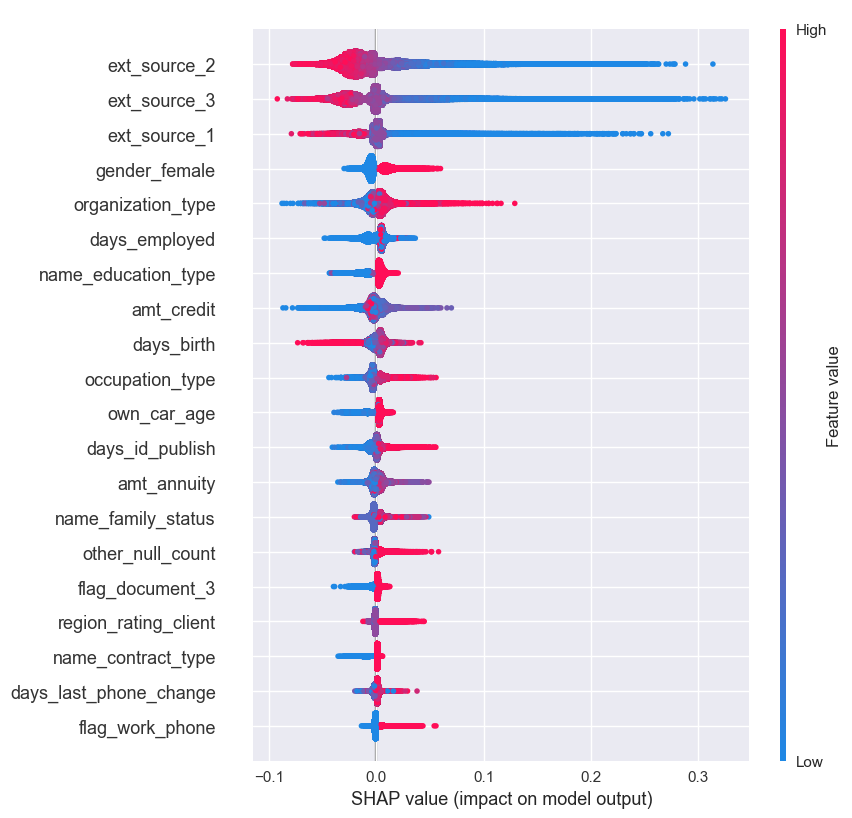

In [364]:
import shap

# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(lgbmc)  # NOTE: this was run on the *categorical* lgbmc
shap_values = explainer.shap_values(X_num_train)

# visualize the first prediction's explanation
shap.summary_plot(shap_values, X_num_train)

## 5. Main table dataset testing

Now that we've got our model baselines, let's check the accuracy produced by `raw_apps_df` vs `apps_df` (cleaned and imputed) vs `apps_small_df` (cleaned, imputed, and reduced).

In [136]:
lgbmc1 = LGBMClassifier(class_weight='balanced')
quick_test_model(lgbmc1, pd.get_dummies(raw_apps_df.drop('target', axis=1)), raw_apps_df.target)

  train AUROC: 0.805
  test AUROC: 0.756
  train f1-score: 0.296
  test f1-score: 0.273
elapsed time: 0.6 minutes


In [137]:
lgbmc1 = LGBMClassifier(class_weight='balanced')
quick_test_model(lgbmc1, pd.get_dummies(apps_df.drop('target', axis=1)), apps_df.target)

  train AUROC: 0.806
  test AUROC: 0.768
  train f1-score: 0.297
  test f1-score: 0.281
elapsed time: 0.4 minutes


In [132]:
lgbmc1 = LGBMClassifier(class_weight='balanced')
quick_test_model(lgbmc1, pd.get_dummies(apps_small_df.drop('target', axis=1)), apps_small_df.target)

  train AUROC: 0.806
  test AUROC: 0.763
  train f1-score: 0.298
  test f1-score: 0.273
elapsed time: 0.4 minutes


It looks like our cleaning and imputation to get to `apps_df` slightly helped our accuracy, but the reduction down to `apps_small_df` slightly hurt it – though these effects are small enough that they're barely significant.  Moving forward, then, we'll work mostly with `apps_df` unless we need a smaller dataset.

### 6. Early feature elimination

# Importance-based feature deletion

We may also be able to achieve accuracy gains, or at the very least performance gains, by eliminating features that don't turn out to be useful for our models.  Later on, will also help our feature reduction algorithm (GLRM) more accurately reduce the features that are important.  Here, we'll sort our feature importances and eliminate features of no or minimal importance.

First, as a baseline, let's check our accuracy on the expanded `X_sm dataset` (with the engineered features) as a baseline:

In [154]:
# X_sm_added = add_eng_cols(X_sm_encoded)  # doesn't work, for inscrutable reasons
X_sm_added = pd.concat([X_sm_added, apps_small_df.iloc[:,-6:]], axis=1) # same thing, different way

In [159]:
lgbmc = LGBMClassifier(class_weight='balanced')
quick_test_model(lgbmc, X_sm_added, y)

  train AUROC: 0.806
  test AUROC: 0.766
  train f1-score: 0.298
  test f1-score: 0.274
elapsed time: 0.3 minutes


While we're here, we can note that this accuracy, both as AUROC and as f1-score, looks just as good as a dummy-version of the dataset as below (and runs slightly faster). This shows that the manual numerical encoding method above (based on mean of the target for each category) works as effectively as dummy columns while avoiding feature proliferation.

In [145]:
lgbmc_dummy = LGBMClassifier(class_weight='balanced')
quick_test_model(lgbmc_dummy, pd.get_dummies(apps_small_df.drop('target', axis=1)), y)

  train AUROC: 0.805
  test AUROC: 0.767
  train f1-score: 0.296
  test f1-score: 0.278
elapsed time: 0.4 minutes


And we can see in the feature importances below that several of our added features were used extensively in our model.

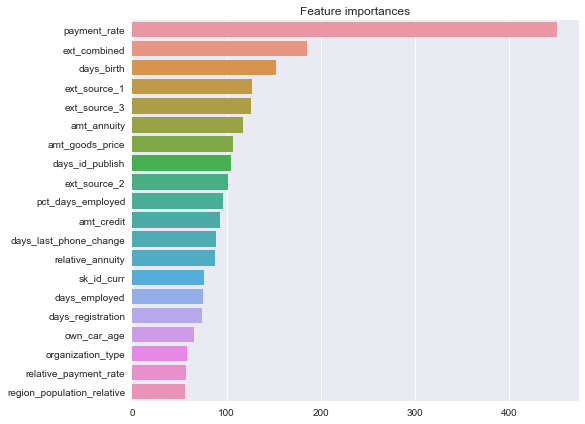

In [160]:
def plot_importances2(X_train, importances):
    labeled_fi = sorted( list(zip(X_train.columns, importances)), key=lambda x: -x[1])
    plt.figure(figsize=(8,7))
    x_imp = [tup[0] for tup in labeled_fi[:20]]
    y_labels = [tup[1] for tup in labeled_fi[:20]]
    sns.barplot(y_labels, x_imp)
    plt.title("Feature importances")
    plt.show()
    
importances = [round(i) for i in lgbmc.feature_importances_]
plot_importances2(X_sm_added, importances)

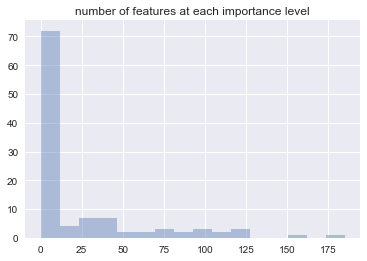

In [162]:
sns.distplot([i for i in importances if i < 400], kde=False) # omit payment_rate at 430 (distorts the plot)
plt.title("number of features at each importance level")
plt.show()

As we can see above, there are a lot of barely significant features.  Let's create a few tiers and try eliminating them and checking our accuracy.

Importance threshold:  0
  test AUROC: 0.761
  test f1-score: 0.274 

Importance threshold:  1
  test AUROC: 0.765
  test f1-score: 0.277 

Importance threshold:  5
  test AUROC: 0.763
  test f1-score: 0.273 

Importance threshold:  10
  test AUROC: 0.765
  test f1-score: 0.279 

Importance threshold:  15
  test AUROC: 0.766
  test f1-score: 0.276 

Importance threshold:  20
  test AUROC: 0.762
  test f1-score: 0.273 

Importance threshold:  30
  test AUROC: 0.761
  test f1-score: 0.273 

Importance threshold:  40
  test AUROC: 0.762
  test f1-score: 0.274 

Importance threshold:  50
  test AUROC: 0.766
  test f1-score: 0.281 

Importance threshold:  65
  test AUROC: 0.765
  test f1-score: 0.276 

Importance threshold:  80
  test AUROC: 0.762
  test f1-score: 0.271 

Importance threshold:  100
  test AUROC: 0.763
  test f1-score: 0.273 



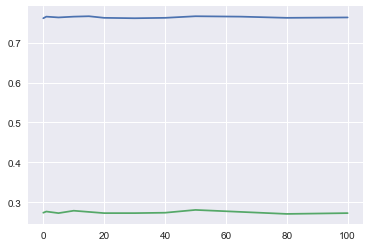

In [163]:
labeled_fi = sorted( list(zip(X_sm_added.columns, importances)), key=lambda x: -x[1])
thresholds = [0,1,5,10,15,20,30,40,50,65,80,100]
aurocs = []
f1_scores = []
for threshold in thresholds:
    featureset = [tup[0] for tup in labeled_fi if tup[1] > threshold]
    
    model = LGBMClassifier(class_weight='balanced')
    X_train, X_test, y_train, y_test = train_test_split(X_sm_added, y, test_size=1/3)
    model.fit(X_train, y_train)
    
    y_test_proba = model.predict_proba(X_test)[:,1]
    y_pred_test = model.predict(X_test)
        
    test_auroc = round(roc_auc_score(y_test, y_test_proba), 3) 
    test_f1 = round(f1_score(y_test, y_pred_test), 3) 
    
    aurocs.append(test_auroc)
    f1_scores.append(test_f1)
    
    print("Importance threshold: ", threshold)
    print("  test AUROC:", test_auroc)
    print("  test f1-score:", test_f1, '\n')

plt.plot(thresholds, aurocs)
plt.plot(thresholds, f1_scores)
plt.show()

It seems as though there is no significant dropoff in accuracy score even eliminating a large majority of our features (the 100 threshold reduces the dataset down to only about 50 features). But there is also no gain, except in performance.  We'll return to this idea later in our final optimizations.  For the sake of our data moving forward, we'll only eliminate the wholly irrelevant data (importance == 0 or 1).

In [ ]:
# eliminate columns whose dummies are never used in the model
useless_cols = [
    'housetype_mode',
    'emergencystate_mode',
    'flag_cont_mobile',
    'flag_emp_phone',
    'flag_mobil',
    'flag_document_6',
    'flag_document_8'
]
apps_df.drop(useless_cols, axis=1, inplace=True)
apps_small_df.drop(useless_cols, axis=1, inplace=True)

In [ ]:
## apps_df.to_csv('apps_df.csv')
## apps_small_df.to_csv('apps_small_df.csv')

# Addenda

In [484]:
best_params = {'class_weight':'balanced',
              'reg_lambda': 1, 
              'reg_alpha': 2, 
              'random_state': 11, 
              'num_leaves': 14, 
              'n_estimators': 300, 
              'min_samples_split': 2, 
              'min_data_in_leaf': 1200, 
              'boosting_type': 'goss'}

train_f1s = []
test_f1s = []
train_aurocs = []
test_aurocs = []

lgbmc_cv4 = LGBMClassifier(**best_params)

start = time()

for i in range(2):
    X_train, X_test, y_train, y_test = train_test_split(full_dummy_df, y, test_size=0.1)
    lgbmc_cv4.fit(X_train, y_train)
    
    y_train_proba = lgbmc_cv4.predict_proba(X_train)[:,1]
    y_test_proba = lgbmc_cv4.predict_proba(X_test)[:,1]
    y_pred_train = lgbmc_cv4.predict(X_train)
    y_pred_test = lgbmc_cv4.predict(X_test)

    train_auroc = round(roc_auc_score(y_train, y_train_proba), 3)
    test_auroc = round(roc_auc_score(y_test, y_test_proba), 3) 
    train_f1 = round(f1_score(y_train, y_pred_train), 3)
    test_f1 = round(f1_score(y_test, y_pred_test), 3)   
 
    train_aurocs.append(train_auroc)
    test_aurocs.append(test_auroc)
    train_f1s.append(train_f1)
    test_f1s.append(test_f1)


train_auroc_error = np.std(train_aurocs)*1.96
test_auroc_error = np.std(test_aurocs)*1.96
train_f1_error = np.std(train_f1)*1.96
test_f1_error = np.std(test_f1)*1.96

print("Final 90/10 cv results at 95% confidence:")

print("\n  train AUROC:", round(np.mean(train_aurocs), 3), "±", round(train_auroc_error, 3))
print("  test AUROC:", round(np.mean(test_aurocs), 3), "±", round(test_auroc_error, 3))
print("     ({} --> {})".format(
    round(np.mean(test_aurocs) - test_auroc_error, 3),
    round(np.mean(test_aurocs) + test_auroc_error, 3)))

print("\n  train f1-score:", round(np.mean(train_f1s), 3), "±", round(train_f1_error, 3))
print("  test f1-score:", round(np.mean(test_f1s), 3), "±", round(test_f1_error, 3))
print("     ({} --> {})".format(
    round(np.mean(test_f1s) - test_f1_error, 3),
    round(np.mean(test_f1s) + test_f1_error, 3)))

print("\nelapsed time:", round((time()-start)/60, 1), 'minutes')

Final 90/10 cv results at 95% confidence:

  train AUROC: 0.823 ± 0.0
  test AUROC: 0.784 ± 0.002
     (0.782 --> 0.786)

  train f1-score: 0.32 ± 0.0
  test f1-score: 0.292 ± 0.0
     (0.292 --> 0.292)

elapsed time: 4.1 minutes


### 1. GLRM on the full dataset

In [287]:
# Load the H2O library and start up the H2O cluster locally on your machine
import h2o
from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,1 min 37 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.11
H2O cluster version age:,2 months and 1 day
H2O cluster name:,garrettfiddler
H2O cluster total nodes:,1
H2O cluster free memory:,2 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


In [295]:
full_h2 = h2o.H2OFrame(full_dataset_df.drop(['sk_id_curr','target'], axis=1), column_types=glrm_column_types)
# column_types are defined at the bottom of this notebook to save space here

full_h2.shape

Parse progress: |█████████████████████████████████████████████████████████| 100%


(307508, 180)

In [245]:
# parameter sweep (one example).  Should sweep through k, multi_loss, init, and perhaps col types
glrmodel_1 = H2OGeneralizedLowRankEstimator(
                                       k=30,
                                       seed=11,
                                       transform="STANDARDIZE",
                                       regularization_x="None", 
                                       regularization_y="None",
                                       init='SVD',
                                       max_iterations=30, 
                                       multi_loss='categorical',
                                       #loss_by_col=[loss_by_col[c] for c in khous_run.columns], 
                                       impute_original=True)

In [246]:
start = time()
glrmodel_1.train(training_frame=full_h2)
print('elapsed time:', round((time()-start)/60, 1), "minutes")
# note: elapsed time is probably only 90-120min; computer was asleep for 5 hrs

glrm Model Build progress: |██████████████████████████████████████████████| 100%
elapsed time: 72.9 minutes


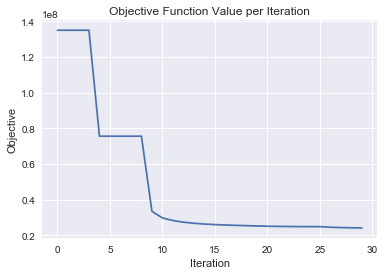

In [247]:
# Plot objective function value each iteration
model_score = glrmodel_1.score_history()
plt.xlabel("Iteration")
plt.ylabel("Objective")
plt.title("Objective Function Value per Iteration")
plt.plot(model_score["iterations"], model_score["objective"])
plt.show()

In [248]:
model = glrmodel_1._model_json
model_out = model['output']
# num_archs = glrmodel_5.params['k']['actual']
archs_df = model_out["archetypes"].as_data_frame()
archs = np.array(archs_df)
X = h2o.get_frame(model_out['representation_name'])
glrm_df = X.as_data_frame()

print('Original:', full_dataset_df.shape)
print('Projected:', glrm_df.shape)

Original: (307508, 182)
Projected: (307508, 30)


In [249]:
glrm_df.to_csv('glrm2_df.csv')

In [377]:
lgbmc_glrm = LGBMClassifier(class_weight='balanced')
quick_test_model(lgbmc_glrm, glrm_df, y)

  train AUROC: 0.799
  test AUROC: 0.737
  train f1-score: 0.294
  test f1-score: 0.259
elapsed time: 0.3 minutes


This shows a notable decrease in accuracy from our full dataset.  And adding the GLRM features to our dataset, either as 'distances'/values or as binaries (like cluster labels), doesn't help our accuracy either (trials omitted for space).

Nevertheless, this dataset will prove quite useful.  Unlike `full_dataset_df`, this dataset is small and null-less; and unlike `apps_small_df` it incorporates information from the ancillary tables as well.  For computationally expensive processing and feature engineering methods, having such a dataset on hand will be convenient.

### 1.5 GLRM for cc_bal_df dataset

We'll also try running this for our overwhelmingly null cc_bal_df dataset (about 93% null) to see if the output could be a helpful addition.

In [252]:
# load
cc_bal_df = pd.read_csv('cc_bal_df.csv', index_col=0)

# drop unneccessary col:
cc_bal_df.drop('sk_id_prev', axis=1, inplace=True)

# merge to sk_id_curr of the full dataset to generate one row per current applicant (many null)
cc_full_df = pd.merge(apps_small_df[['sk_id_curr', 'target']], cc_bal_df, on='sk_id_curr', how='left')
cc_full_df.drop(['target', 'sk_id_curr'],axis=1, inplace=True)

# create h2o dataset
cc_full_h2 = h2o.H2OFrame(cc_full_df, column_types=['real' for i in range(47)])

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [253]:
glrmodel_cc = H2OGeneralizedLowRankEstimator(
                                       k=5,
                                       seed=14,
                                       transform="STANDARDIZE",
                                       regularization_x="None", 
                                       regularization_y="None",
                                       init='SVD',
                                       max_iterations=40, 
                                       multi_loss='categorical',
                                       #loss_by_col=[loss_by_col[c] for c in khous_run.columns], 
                                       impute_original=True)

In [254]:
start = time()
glrmodel_cc.train(training_frame=cc_full_h2)
print('elapsed time:', round((time()-start)/60, 1), "minutes")

glrm Model Build progress: |██████████████████████████████████████████████| 100%
elapsed time: 0.8 minutes


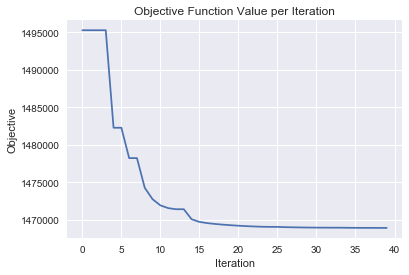

In [255]:
# Plot objective function value each iteration
model_score = glrmodel_cc.score_history()
plt.xlabel("Iteration")
plt.ylabel("Objective")
plt.title("Objective Function Value per Iteration")
plt.plot(model_score["iterations"], model_score["objective"])
plt.show()

In [512]:
# Load the H2O library and start up the H2O cluster locally on your machine
import h2o
from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,08 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.11
H2O cluster version age:,2 months and 9 days
H2O cluster name:,garrettfiddler
H2O cluster total nodes:,1
H2O cluster free memory:,2 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [515]:
h2set = pd.concat(
    [full_dataset_df[top_37_features], apps_df[['occupation_type', 'name_education_type', 'name_family_status']]],
    axis=1)

quick_test_model(lgbmc, full_dummy_df, y)

imp_h2 = h2o.H2OFrame(h2set, column_types=glrm_coltypes_small)
del h2set

imp_h2.shape

Parse progress: |█████████████████████████████████████████████████████████| 100%


(307508, 40)

In [516]:
glrmodel_imp = H2OGeneralizedLowRankEstimator(
                                       k=20,
                                       seed=11,
                                       transform="STANDARDIZE",
                                       regularization_x="None", 
                                       regularization_y="None",
                                       init='SVD',
                                       max_iterations=30, 
                                       multi_loss='categorical',
                                       #loss_by_col=[loss_by_col[c] for c in khous_run.columns], 
                                       impute_original=True)

In [517]:
start = time()
glrmodel_imp.train(training_frame=imp_h2)
print('elapsed time:', round((time()-start)/60, 1), "minutes")

glrm Model Build progress: |██████████████████████████████████████████████| 100%
elapsed time: 4.7 minutes


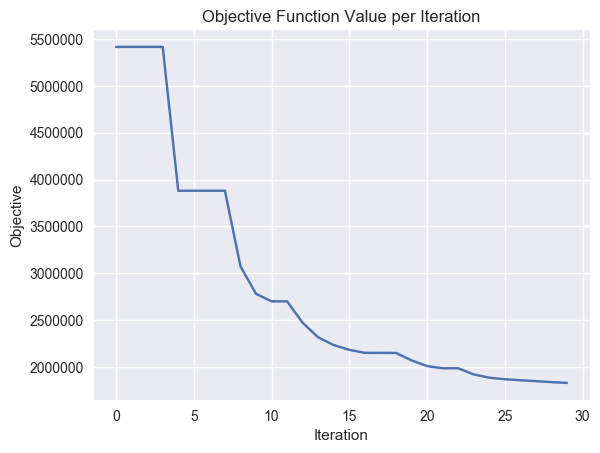

In [518]:
model_score = glrmodel_imp.score_history()
plt.xlabel("Iteration")
plt.ylabel("Objective")
plt.title("Objective Function Value per Iteration")
plt.plot(model_score["iterations"], model_score["objective"])
plt.show()

In [520]:
model = glrmodel_imp._model_json
model_out = model['output']
# num_archs = glrmodel_5.params['k']['actual']
archs_df = model_out["archetypes"].as_data_frame()
archs = np.array(archs_df)
X = h2o.get_frame(model_out['representation_name'])
glrm_imp20_df = X.as_data_frame()

print('Projected shape:', glrm_imp20_df.shape)

Projected shape: (307508, 20)


In [521]:
lgbmc_glrm = LGBMClassifier(class_weight='balanced')
quick_test_model(lgbmc_glrm, glrm_imp20_df, y)

  train AUROC: 0.79
  test AUROC: 0.74
  train f1-score: 0.284
  test f1-score: 0.259
elapsed time: 0.2 minutes


In [529]:
glrm_imp20_df.to_csv('glrm_imp20.csv')
glrm_imp30_df.to_csv('glrm_imp30.csv')

#### k=2 - new glrm_vis

In [531]:
glrmodel_impvis = H2OGeneralizedLowRankEstimator(
                                       k=2,
                                       seed=11,
                                       transform="STANDARDIZE",
                                       regularization_x="None", 
                                       regularization_y="None",
                                       init='SVD',
                                       max_iterations=30, 
                                       multi_loss='categorical',
                                       #loss_by_col=[loss_by_col[c] for c in khous_run.columns], 
                                       impute_original=True)

In [532]:
start = time()
glrmodel_impvis.train(training_frame=imp_h2)
print('elapsed time:', round((time()-start)/60, 1), "minutes")

glrm Model Build progress: |██████████████████████████████████████████████| 100%
elapsed time: 1.0 minutes


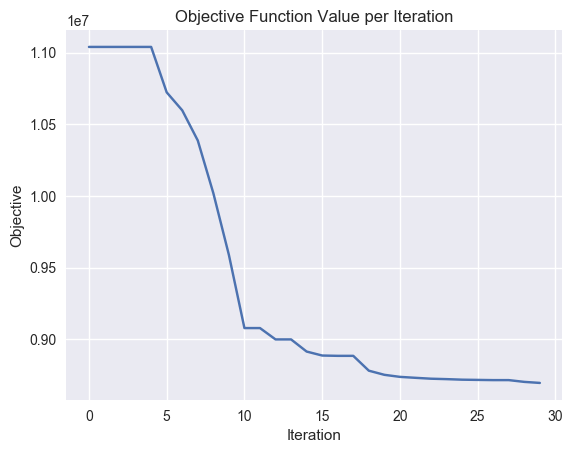

In [533]:
model_score = glrmodel_impvis.score_history()
plt.xlabel("Iteration")
plt.ylabel("Objective")
plt.title("Objective Function Value per Iteration")
plt.plot(model_score["iterations"], model_score["objective"])
plt.show()

In [534]:
model = glrmodel_impvis._model_json
model_out = model['output']
# num_archs = glrmodel_5.params['k']['actual']
archs_df = model_out["archetypes"].as_data_frame()
archs = np.array(archs_df)
X = h2o.get_frame(model_out['representation_name'])
glrm_vis_df = X.as_data_frame()

print('Original:', full_dataset_df.shape)
print('Projected:', glrm_vis_df.shape)

Original: (307508, 183)
Projected: (307508, 2)


In [535]:
lgbmc_glrm = LGBMClassifier(class_weight='balanced')
quick_test_model(lgbmc_glrm, glrm_vis_df, y)

  train AUROC: 0.674
  test AUROC: 0.655
  train f1-score: 0.207
  test f1-score: 0.204
elapsed time: 0.1 minutes


In [540]:
glrm_vis_df.to_csv('glrm_vis_imp.csv')

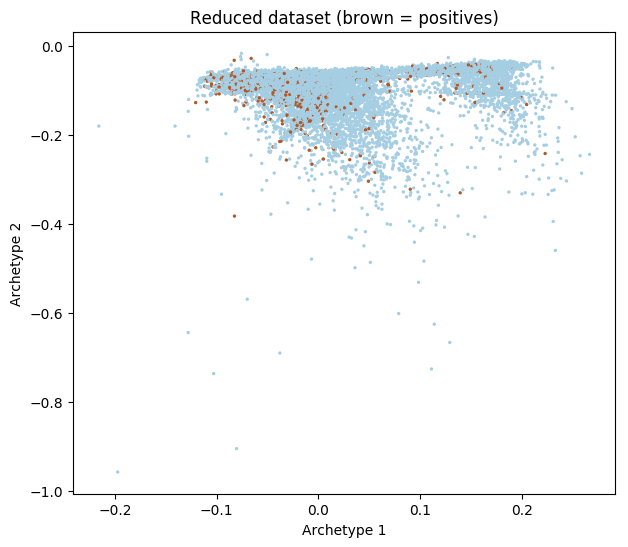

In [539]:
sns.reset_orig()
plt.figure(figsize=(7,6))
# sample = pd.Series(range(307508)).sample(frac=0.05)
plt.scatter(glrm_vis_df.Arch1.iloc[sample], 
            glrm_vis_df.Arch2.iloc[sample], 
            s=2, 
            c=pd.Series(y).iloc[sample],
            cmap='Paired')
plt.xlabel("Archetype 1")
plt.ylabel("Archetype 2")
plt.title("Reduced dataset (brown = positives)")
plt.show()
sns.set()

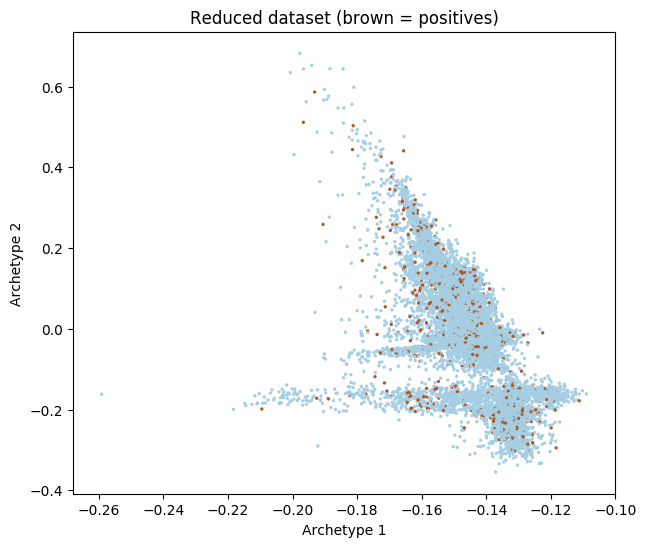

In [228]:
sns.reset_orig()
plt.figure(figsize=(7,6))
# sample = pd.Series(range(307508)).sample(frac=0.05)
plt.scatter(glrm_vis_df.Arch1.iloc[sample], 
            glrm_vis_df.Arch2.iloc[sample], 
            s=2, 
            c=pd.Series(y).iloc[sample],
            cmap='Paired')
plt.xlabel("Archetype 1")
plt.ylabel("Archetype 2")
plt.title("Reduced dataset (brown = positives)")
plt.show()
sns.set()

### 2. cc_df tests

In [544]:
cc_bal_df = pd.read_csv('cc_bal_df.csv', index_col=0)
cc_bal_df.head()

,sk_id_curr,sk_id_prev,months_balance_mean,months_balance_var,amt_balance_mean,amt_balance_var,amt_credit_limit_actual_mean,amt_credit_limit_actual_var,amt_drawings_atm_current_mean,amt_drawings_atm_current_var,...,sk_dpd_var,sk_dpd_def_mean,sk_dpd_def_var,pct_unpaid_mean,pct_unpaid_var,name_contract_status_Active_mean,name_contract_status_Completed_mean,name_contract_status_Demand_mean,name_contract_status_Sent proposal_mean,name_contract_status_Signed_mean
0,100006,1489396.0,-3.5,3.5,0.000000,0.000000e+00,270000.000000,0.000000e+00,NaN,NaN,...,0.000000,0.000000,0.000000,NaN,NaN,1.000000,0.000000,0.0,0.0,0.0
1,100011,1843384.0,-38.5,462.5,54482.111149,4.641321e+09,164189.189189,1.189060e+09,2432.432432,4.378378e+08,...,0.000000,0.000000,0.000000,-323.516221,93486.891004,1.000000,0.000000,0.0,0.0,0.0
2,100013,2038692.0,-48.5,776.0,18159.919219,1.869473e+09,131718.750000,2.259252e+09,6350.000000,8.249688e+08,...,0.010417,0.010417,0.010417,-272.850682,157769.356383,1.000000,0.000000,0.0,0.0,0.0
3,100021,2594025.0,-10.0,25.5,0.000000,0.000000e+00,675000.000000,0.000000e+00,NaN,NaN,...,0.000000,0.000000,0.000000,NaN,NaN,0.411765,0.588235,0.0,0.0,0.0
4,100023,1499902.0,-7.5,6.0,0.000000,0.000000e+00,135000.000000,9.257143e+09,NaN,NaN,...,0.000000,0.000000,0.000000,NaN,NaN,1.000000,0.000000,0.0,0.0,0.0


In [560]:
cc_bal_df.shape

(103558, 49)

In [550]:
cc_all = pd.merge(left=pd.DataFrame(full_dummy_df.sk_id_curr), right=cc_bal_df, on='sk_id_curr', how='left')

In [559]:
cc_all.head()

,sk_id_curr,sk_id_prev,months_balance_mean,months_balance_var,amt_balance_mean,amt_balance_var,amt_credit_limit_actual_mean,amt_credit_limit_actual_var,amt_drawings_atm_current_mean,amt_drawings_atm_current_var,...,sk_dpd_var,sk_dpd_def_mean,sk_dpd_def_var,pct_unpaid_mean,pct_unpaid_var,name_contract_status_Active_mean,name_contract_status_Completed_mean,name_contract_status_Demand_mean,name_contract_status_Sent proposal_mean,name_contract_status_Signed_mean
0,100002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,1489396.0,-3.5,3.5,0.0,0.0,270000.0,0.0,NaN,NaN,...,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,0.0,0.0
4,100007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [561]:
lgbmc = LGBMClassifier(class_weight='balanced')
quick_test_model(lgbmc, cc_all.drop(['sk_id_curr', 'sk_id_prev'], axis=1), y)

  train AUROC: 0.629
  test AUROC: 0.558
  train f1-score: 0.223
  test f1-score: 0.149
elapsed time: 0.2 minutes


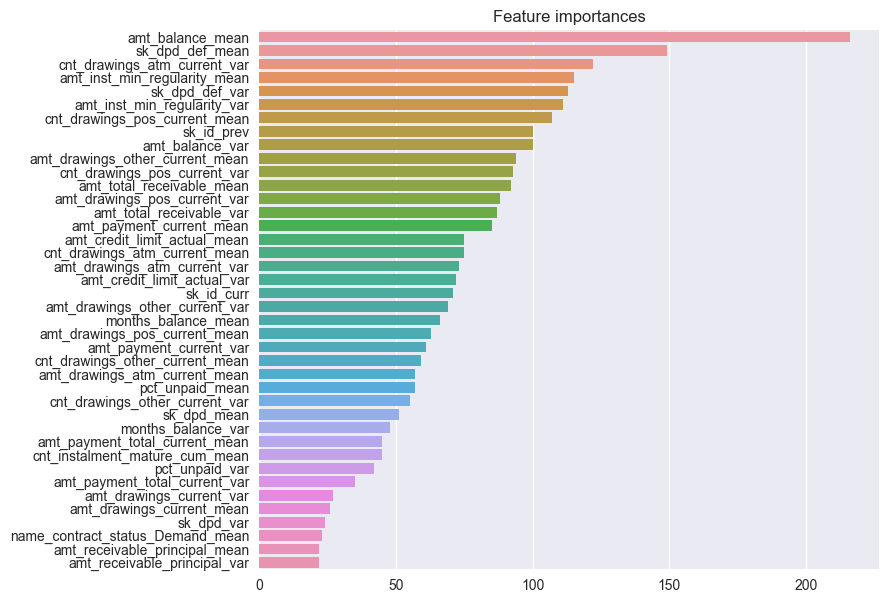

In [563]:
importances = [round(i) for i in lgbmc.feature_importances_]
plot_importances2(cc_all, importances)
labeled_fi = sorted( list(zip(cc_all.columns, importances)), key=lambda x: -x[1])

In [564]:
lgbmc1 = LGBMClassifier(class_weight='balanced')
quick_test_model(lgbmc, pd.concat(
    [full_dummy_df, cc_all.drop(['sk_id_curr', 'sk_id_prev'], axis=1)], 
        axis=1), 
    y)

  train AUROC: 0.833
  test AUROC: 0.781
  train f1-score: 0.324
  test f1-score: 0.288
elapsed time: 1.9 minutes


In [565]:
top_5 = [tup[0] for tup in labeled_fi[:5]]
top_5

['amt_balance_mean',
 'sk_dpd_def_mean',
 'cnt_drawings_atm_current_var',
 'amt_inst_min_regularity_mean',
 'sk_dpd_def_var']

In [566]:
lgbmc1 = LGBMClassifier(class_weight='balanced')
quick_test_model(lgbmc, pd.concat(
    [full_dummy_df, cc_all[top_5]], 
        axis=1), 
    y)

  train AUROC: 0.833
  test AUROC: 0.78
  train f1-score: 0.322
  test f1-score: 0.291
elapsed time: 1.4 minutes


In [568]:
test_feature(cc_all[top_5])

Train AUROC mean gain as z-score: 7.61
Test AUROC mean gain as z-score: 1.49
Train f1-score mean gain as z-score: 1.77
Test f1-score mean gain as z-score: 2.3
  (elapsed time: 2.0 minutes)


### 3. iterated add-next-prev_df and ft importance test

Probably optimal:
- get mean, min, max, and var for ALL past apps (including prev) --> test for importance
- get prev columns for previous two or three prev apps --> test for importance

I expect that VARIANCE may be a very important stat for some of these - especially income.

In [ ]:
# LOAD AND CLEAN:
previous_df = pd.read_csv("previous_application.csv")
previous_df.columns = [str.lower(column) for column in previous_df.columns]

# fill accompanying person and downpayment appropriately
previous_df['name_type_suite'].fillna(value='Unaccompanied', inplace=True)
previous_df['amt_down_payment'].fillna(value=0, inplace=True)

# convert Y/N to boolean
previous_df['flag_last_appl_per_contract'] = previous_df['flag_last_appl_per_contract']=='Y'

# drop three columns that are overwhelmingly null
previous_df.drop(['rate_down_payment',
                  'rate_interest_primary',
                  'rate_interest_privileged',
                  'name_cash_loan_purpose'], 
                 axis=1, inplace=True)

In [ ]:
# define utility functions for splitting prev (most recent) vs past and grouping past applications by applicant
def split_past_prev(df, time_col, past_id):
    '''
    time_col = column that contains days since application
    past_id = column that contains id of the loan represented by the row
    '''
    start = time()
    df = df.sort_values(by=['sk_id_curr', time_col]) # each group sorted by days_decision so most recent is last
    prev_df = df.groupby('sk_id_curr').nth(-1) # selects last entry from each group
    past_df = df[~df[past_id].isin(prev_df[past_id])] # selects all entries not in previous_df
    prev_df.reset_index(inplace=True)
    print("Elapsed time (minutes):", round((time()-start)/60, 1))
    return (past_df, prev_df)

def categorical_mode(series):
    if series.count() == 0:
        return float('NaN')
    else:
        return series.mode()[0]

def group_apps(df, count_col, cats_to_encode=[]):
    start = time()
    
    # eliminate spaces from column names:
    df.columns = [col.replace(' ', '_') for col in df.columns]
    
    cat_cols = []
    for col in df.columns:
        if df.dtypes[col] == 'object' and col not in cats_to_encode:
            cat_cols.append(col)
    num_cols = [col for col in df.columns if col not in (cat_cols + cats_to_encode)]
    df = pd.get_dummies(df, columns=cats_to_encode)
    # eliminate spaces from column names:
    df.columns = [col.replace(' ', '_') for col in df.columns]
    dummy_cols = [col for col in df.columns if col not in (num_cols + cat_cols + cats_to_encode)]
    
    agg_funcs = {}
    for col in dummy_cols:
        agg_funcs[col] = ['mean', 'var', 'sum']
    for col in num_cols:
        agg_funcs[col] = ['min', 'max', 'mean', 'var']  # alternative: ['mean', 'var']
    for col in cat_cols:
        agg_funcs[col] = [categorical_mode, 'nunique']  # categorical_mode = custom function defined above
    agg_funcs[count_col] = 'count'  # we'll rename this prev_app_count below
    
    print("Performing groupby...")
    grouped_df = df.groupby('sk_id_curr').agg(agg_funcs)  # NOTE: takes a while
    grouped_df.rename(columns={count_col:'prev_app_count'}, inplace=True)
    
    print("Elapsed time (minutes):", round((time()-start)/60, 1))
    return grouped_df

past_df, prev_df = split_past_prev(all_previous_df, 
                                   time_col='days_decision', 
                                   past_id='sk_id_prev')
past_df = group_apps(past_df, 
                     count_col='sk_id_prev', 
                     cats_to_encode=['name_contract_type','name_contract_status','name_payment_type'])

In [ ]:
# pull prev_1 from past; save restOfPast
past_df, prev1_df = split_past_prev(all_previous_df, 
                                   time_col='days_decision', 
                                   past_id='sk_id_prev')

past1_df, prev2_df = split_past_prev(past_df,
                                   time_col='days_decision', 
                                   past_id='sk_id_prev')
past_df = group_apps(past_df, 
                     count_col='sk_id_prev', 
                     cats_to_encode=['name_contract_type','name_contract_status','name_payment_type'])

# pull prev_2 from restOfPast
# do maximalist summary of all data (including first two)
# include COUNT, NUM DIFFERENT JOBS, and AMT INCREASE OVER PREV APPROVED LOAN
# do feature testing and elimination

In [ ]:
# pull prev_1 from past; save restOfPast


# pull prev_2 from restOfPast


# do maximalist summary of all data (including first two)
# include COUNT, NUM DIFFERENT JOBS, and AMT INCREASE OVER PREV APPROVED LOAN



# do feature testing and elimination

### 4. get catboost running with categoricals

### 5. examine misclassifications & null counts

And then train a model (maybe non-tree-based?)  with misclassification as the target.  See if I can predict misclassification!  This will improve my accuracy IFF I have more true positives than false positives.

### 6. try an SVM on the gnb / lgbmc ensemble

### 7. misc

- try encoding organization_type target var as well as target mean